**Исходные данные**

В качестве [датасета](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data) для анализа взяты данные о бронировании авиабилетов на сайте "EaseMyTrip" – популярной интернет-платформе для покупки билетов потенциальными пассажирами. Датасет содержит сведения о забронированных местах для путешествий между городами Индии и включает следующие столбцы:
* **airline** – категориальный признак, представляющий название авиакомпании;  
* **flight** – содержит информацию о коде рейса самолёта;  
* **source_city** – город отправления рейса;
* **departure_time** – время вылета;  
* **stops** – количество остановок между городом отправления и городом назначения;
* **arrival_time** – временная метка прибытия; 
* **destination_city** – город назначения;  
* **class** – категориальная фича, содержащая информацию о классе места (эконом или бизнес);  
* **duration** – продолжительность рейса в часах;  
* **days_left** – количество дней от даты бронирования до даты рейса;  
* **price** – непрерывный признак, содержащий информацию о цене билета. 

**Какова цель данного исследования?**  
Исследование направлено на то, чтобы понять, между какими признаками наблюдается зависимость, существуют ли статистически значимые различия между группами бронировай по тем или иным признакам, как различные признаки (авиакомпания, город назначения, продолжительность рейса и т.д.) влияют на ценообразование билета.

# EDA

In [149]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import mplcyberpunk
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Подгрузим полезные функции
from utils import *

%matplotlib inline

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
pd.set_option('display.float_format', '{:.8f}'.format)
pd.set_option('future.no_silent_downcasting', True)

In [151]:
# Стиль
plt.style.use('cyberpunk')

In [152]:
# Параметры шрифта
plt.rcParams.update({'font.size': 13})

In [153]:
df = pd.read_csv('flight_price_prediction_data.csv')

In [154]:
df.shape

(300153, 12)

In [155]:
df.head()

Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class   duration  days_left  price  
0          Night           Mumbai  Economy 2.17000000          1   5953  
1        Morning           Mumbai  Economy 2.33000000          1   5953  
2  Early_Morning           Mumbai  Economy 2.17000000          1   5956  
3      Afternoon           Mumbai  Economy 2.25000000          1   5955  
4        Morning           Mumbai  Economy 2.33000000          1   5955

In [156]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [157]:
df.head()

airline   flight source_city departure_time stops   arrival_time  \
0  SpiceJet  SG-8709       Delhi        Evening  zero          Night   
1  SpiceJet  SG-8157       Delhi  Early_Morning  zero        Morning   
2   AirAsia   I5-764       Delhi  Early_Morning  zero  Early_Morning   
3   Vistara   UK-995       Delhi        Morning  zero      Afternoon   
4   Vistara   UK-963       Delhi        Morning  zero        Morning   

  destination_city    class   duration  days_left  price  
0           Mumbai  Economy 2.17000000          1   5953  
1           Mumbai  Economy 2.33000000          1   5953  
2           Mumbai  Economy 2.17000000          1   5956  
3           Mumbai  Economy 2.25000000          1   5955  
4           Mumbai  Economy 2.33000000          1   5955

In [158]:
# Посмотрим на наличие пропусков
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [159]:
# Посмотрим на наличие дублирующихся строк
df.duplicated().sum()

0

In [160]:
# Общая сводка по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [161]:
# Формируем отчёт
pdf = PdfPages('report.pdf')

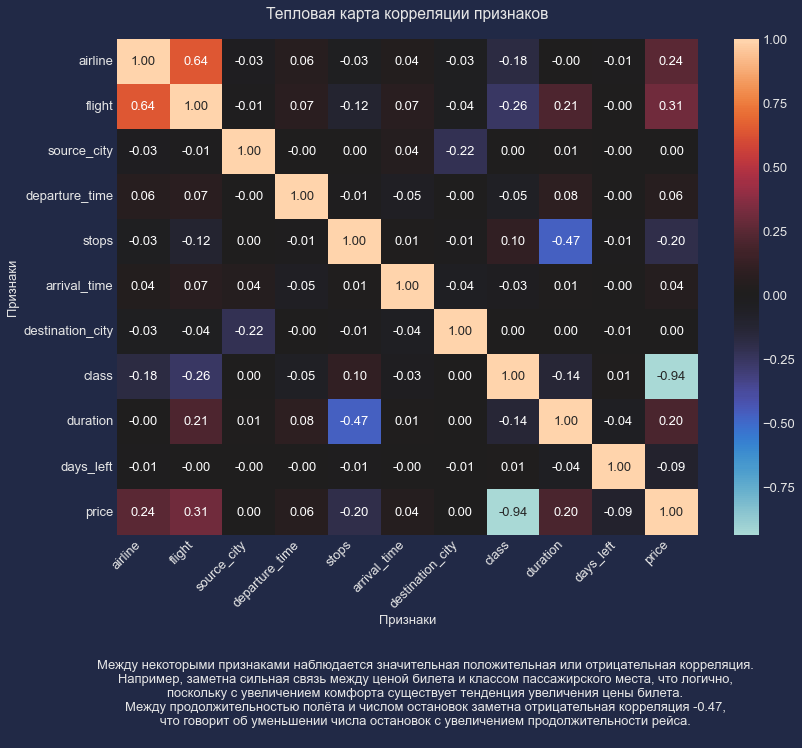

In [162]:
transformed_df = df.copy()

# Преобразование категориальных признаков в числовые
label_encoder = LabelEncoder()
for col in transformed_df.columns:
    if transformed_df[col].dtype == 'object':
        transformed_df[col] = label_encoder.fit_transform(transformed_df[col])

# Построение матрицы корреляции
corr = transformed_df.corr()

fig = plt.figure(figsize=(12, 9))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, center=0, annot=True, fmt=".2f")
plt.title('Тепловая карта корреляции признаков', pad=20)
plt.xlabel('Признаки')
plt.ylabel('Признаки')
# Вращение меток для улучшения читаемости
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

caption_text = '''
Между некоторыми признаками наблюдается значительная положительная или отрицательная корреляция.
Например, заметна сильная связь между ценой билета и классом пассажирского места, что логично,
поскольку с увеличением комфорта существует тенденция увеличения цены билета.
Между продолжительностью полёта и числом остановок заметна отрицательная корреляция -0.47,
что говорит об уменьшении числа остановок с увеличением продолжительности рейса.
'''

plt.figtext(0.5, -0.15, caption_text, ha="center", fontsize=13)

pdf.savefig(fig, bbox_inches='tight')

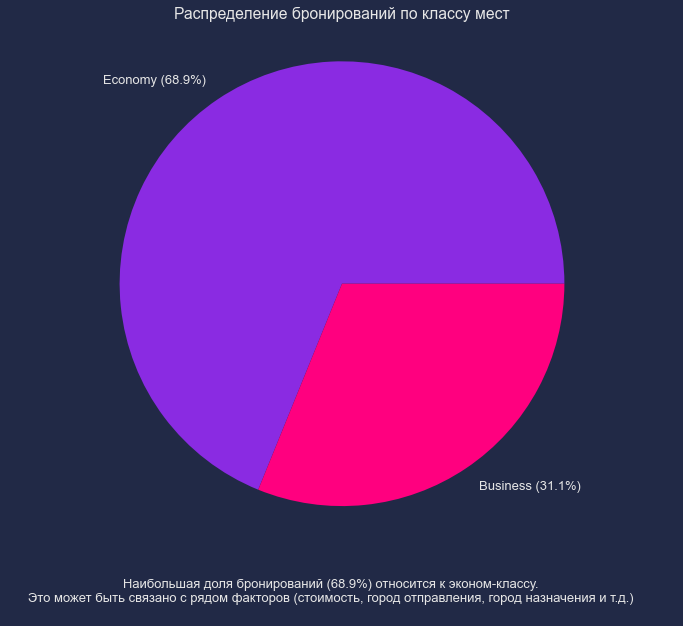

In [163]:
income_counts = df['class'].value_counts()
labels = [f'{label} ({perc:1.1f}%)' for label, perc in zip(income_counts.index, 100 * income_counts / income_counts.sum())]

fig = plt.figure(figsize=(12, 9))
plt.pie(income_counts, labels=labels, colors=['#8a2be2', '#ff007f'])
plt.title('Распределение бронирований по классу мест', pad=20)
plt.axis('equal')

caption_text = '''
Наибольшая доля бронирований (68.9%) относится к эконом-классу.
Это может быть связано с рядом факторов (стоимость, город отправления, город назначения и т.д.)
'''

plt.figtext(0.5, -0.01, caption_text, ha="center", fontsize=13)

pdf.savefig(fig, bbox_inches='tight')

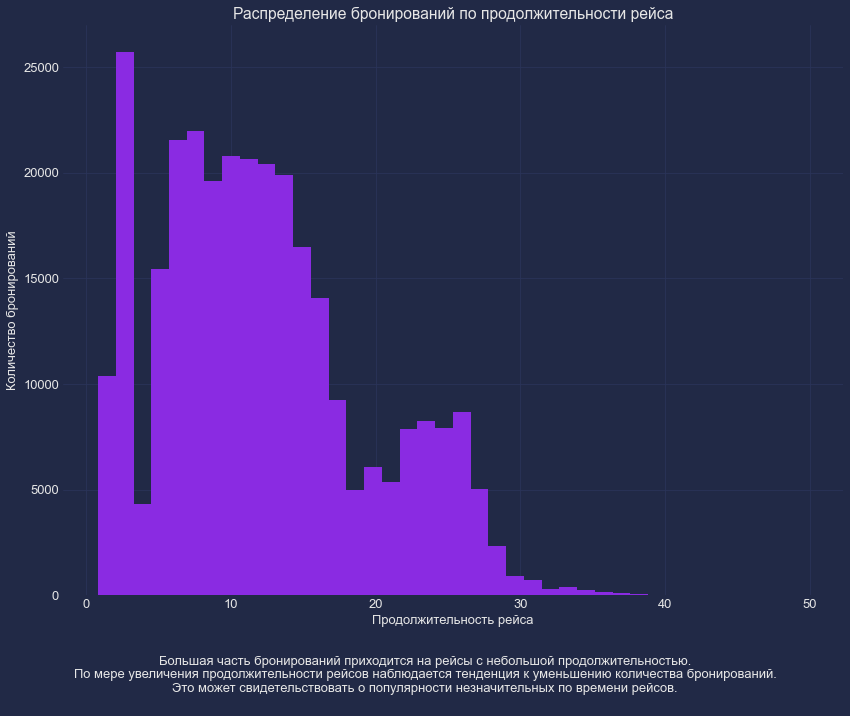

In [164]:
fig = plt.figure(figsize=(12, 9))
plt.hist(df['duration'], bins=40, color='#8a2be2')
plt.title('Распределение бронирований по продолжительности рейса')
plt.xlabel('Продолжительность рейса')
plt.ylabel('Количество бронирований')
plt.tight_layout()

caption_text = '''
Большая часть бронирований приходится на рейсы с небольшой продолжительностью.
По мере увеличения продолжительности рейсов наблюдается тенденция к уменьшению количества бронирований.
Это может свидетельствовать о популярности незначительных по времени рейсов.
'''

plt.figtext(0.5, -0.1, caption_text, ha="center", fontsize=13)

pdf.savefig(fig, bbox_inches='tight')

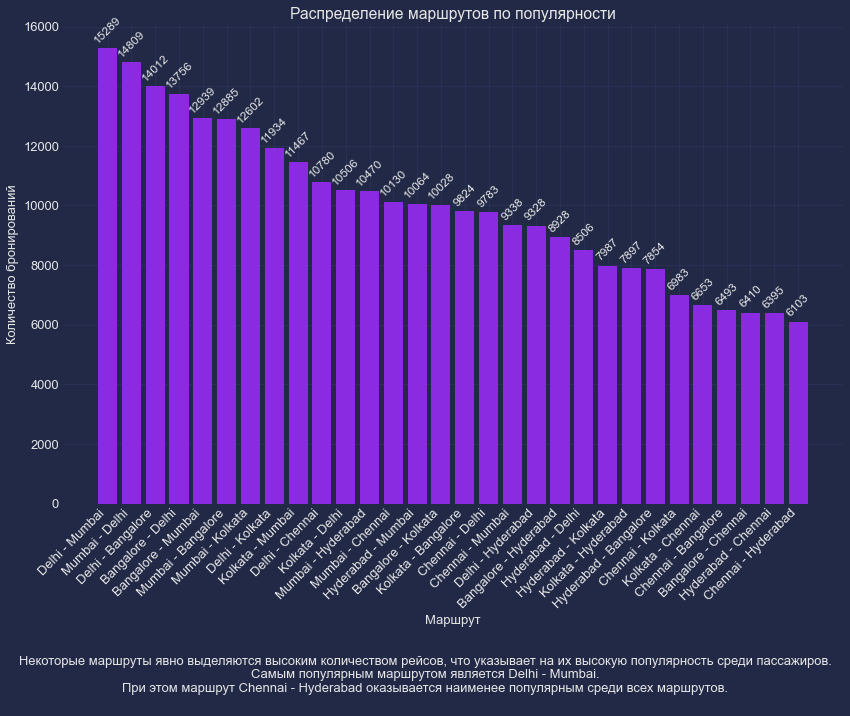

In [165]:
# Посмотрим на популярность маршрутов
routes_popularity = df.groupby(['source_city', 'destination_city']).size().reset_index(name='count').sort_values('count', ascending=False)
routes_popularity['route'] = routes_popularity['source_city'] + ' - ' + routes_popularity['destination_city']
fig = plt.figure(figsize=(12, 9))
plt.bar(routes_popularity['route'].values, routes_popularity['count'].values, color='#8a2be2')
plt.xticks(rotation=45, ha="right")
for route, count in zip(routes_popularity['route'].values, routes_popularity['count'].values):
    plt.text(route, count + 100, count, rotation=45, horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.title('Распределение маршрутов по популярности')
plt.xlabel('Маршрут')
plt.ylabel('Количество бронирований')
plt.tight_layout()

caption_text = '''
Некоторые маршруты явно выделяются высоким количеством рейсов, что указывает на их высокую популярность среди пассажиров.
Самым популярным маршрутом является Delhi - Mumbai.
При этом маршрут Chennai - Hyderabad оказывается наименее популярным среди всех маршрутов.
'''

plt.figtext(0.5, -0.1, caption_text, ha="center", fontsize=13)

pdf.savefig(fig, bbox_inches='tight')

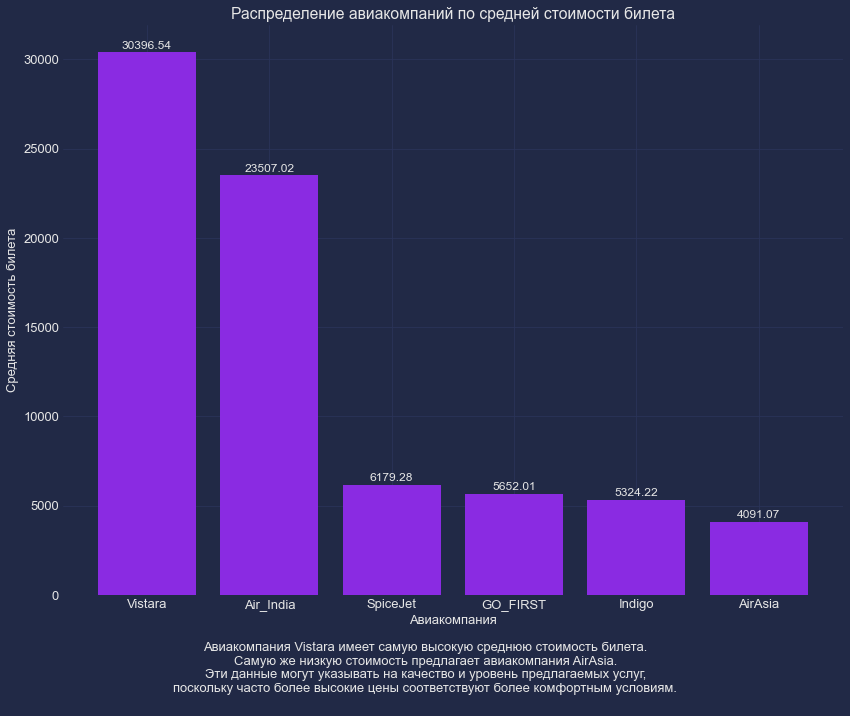

In [166]:
# Посмотрим на среднюю стоимость билетов в каждой авиакомпании
airlines_mean_price = df.groupby('airline')['price'].mean().reset_index().sort_values('price', ascending=False)

fig = plt.figure(figsize=(12, 9))
plt.bar(airlines_mean_price['airline'].values, airlines_mean_price['price'].values, color='#8a2be2')
for airline, price in zip(airlines_mean_price['airline'].values, airlines_mean_price['price'].values):
    plt.text(airline, price + 100, round(price, 2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.title('Распределение авиакомпаний по средней стоимости билета')
plt.xlabel('Авиакомпания')
plt.ylabel('Средняя стоимость билета')
plt.tight_layout()

caption_text = '''
Авиакомпания Vistara имеет самую высокую среднюю стоимость билета.
Самую же низкую стоимость предлагает авиакомпания AirAsia.
Эти данные могут указывать на качество и уровень предлагаемых услуг,
поскольку часто более высокие цены соответствуют более комфортным условиям.
'''

plt.figtext(0.5, -0.1, caption_text, ha="center", fontsize=13)

pdf.savefig(fig, bbox_inches='tight')

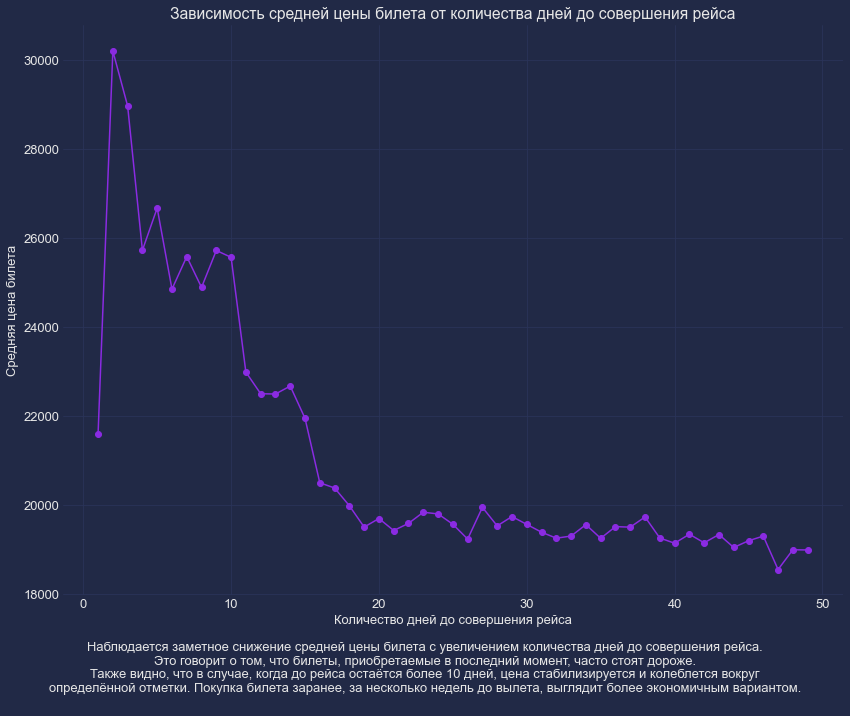

In [167]:
# Агрегация средней цены билета по количеству дней до полёта
avg_price_by_age = df.groupby('days_left')['price'].mean()

fig = plt.figure(figsize=(12, 9))
plt.plot(avg_price_by_age.index, avg_price_by_age.values, marker='o', linestyle='-', color='#8a2be2')
plt.title('Зависимость средней цены билета от количества дней до совершения рейса')
plt.xlabel('Количество дней до совершения рейса')
plt.ylabel('Средняя цена билета')
plt.tight_layout()

caption_text = '''
Наблюдается заметное снижение средней цены билета с увеличением количества дней до совершения рейса.
Это говорит о том, что билеты, приобретаемые в последний момент, часто стоят дороже.
Также видно, что в случае, когда до рейса остаётся более 10 дней, цена стабилизируется и колеблется вокруг
определённой отметки. Покупка билета заранее, за несколько недель до вылета, выглядит более экономичным вариантом.
'''

plt.figtext(0.5, -0.1, caption_text, ha="center", fontsize=13, transform=fig.transFigure)
pdf.savefig(fig, bbox_inches='tight')

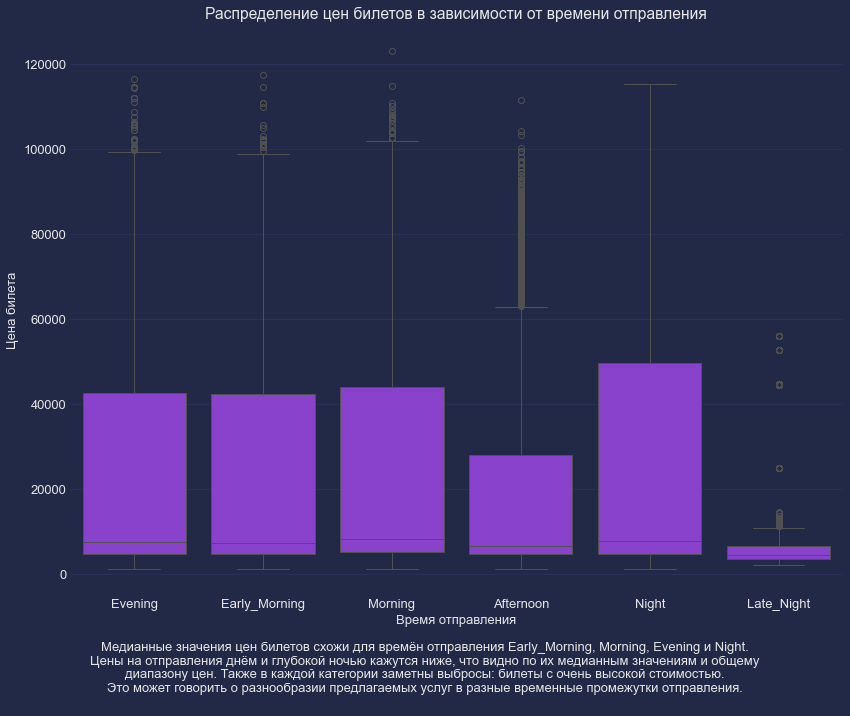

In [168]:
fig = plt.figure(figsize=(12, 9))
sns.boxplot(x='departure_time', y='price', data=df, color='#8a2be2')
plt.title('Распределение цен билетов в зависимости от времени отправления')
plt.xlabel('Время отправления')
plt.ylabel('Цена билета')
plt.tight_layout()

caption_text = '''
Медианные значения цен билетов схожи для времён отправления Early_Morning, Morning, Evening и Night.
Цены на отправления днём и глубокой ночью кажутся ниже, что видно по их медианным значениям и общему
диапазону цен. Также в каждой категории заметны выбросы: билеты с очень высокой стоимостью.
Это может говорить о разнообразии предлагаемых услуг в разные временные промежутки отправления.
'''

plt.figtext(0.5, -0.1, caption_text, ha="center", fontsize=13)

pdf.savefig(fig, bbox_inches='tight')

# Сегментация наблюдений и проведение статистических тестов

Сегментируем бронирования по срочности путешествия ($\textit{days_left}$):
* менее 10 дней;
* от 11 до 20 дней;
* от 21 до 30 дней;
* от 31 до 40 дней;
* более 40 дней.

Будем сравнивать и анализировать по сегментам следующие показатели:
* продолжительность путешествия;
* цена билета.

In [169]:
days_left_bins = [0, 10, 20, 30, 40, max(df['days_left'])]
days_left_labels = ['< 10 days', '11-20 days', '21-30 days', '31-40 days', '> 40 days']
df['days_left_segment'] = pd.cut(df['days_left'], bins=days_left_bins, labels=days_left_labels)

df

airline   flight source_city departure_time stops   arrival_time  \
0       SpiceJet  SG-8709       Delhi        Evening  zero          Night   
1       SpiceJet  SG-8157       Delhi  Early_Morning  zero        Morning   
2        AirAsia   I5-764       Delhi  Early_Morning  zero  Early_Morning   
3        Vistara   UK-995       Delhi        Morning  zero      Afternoon   
4        Vistara   UK-963       Delhi        Morning  zero        Morning   
...          ...      ...         ...            ...   ...            ...   
300148   Vistara   UK-822     Chennai        Morning   one        Evening   
300149   Vistara   UK-826     Chennai      Afternoon   one          Night   
300150   Vistara   UK-832     Chennai  Early_Morning   one          Night   
300151   Vistara   UK-828     Chennai  Early_Morning   one        Evening   
300152   Vistara   UK-822     Chennai        Morning   one        Evening   

       destination_city     class    duration  days_left  price  \
0                Mumbai   Economy  2.17000000          1   5953   
1                Mumbai   Economy  2.33000000          1   5953   
2                Mumbai   Economy  2.17000000          1   5956   
3                Mumbai   Economy  2.25000000          1   5955   
4                Mumbai   Economy  2.33000000          1   5955   
...                 ...       ...         ...        ...    ...   
300148        Hyderabad  Business 10.08000000         49  69265   
300149        Hyderabad  Business 10.42000000         49  77105   
300150        Hyderabad  Business 13.83000000         49  79099   
300151        Hyderabad  Business 10.00000000         49  81585   
300152        Hyderabad  Business 10.08000000         49  81585   

       days_left_segment  
0              < 10 days  
1              < 10 days  
2              < 10 days  
3              < 10 days  
4              < 10 days  
...                  ...  
300148         > 40 days  
300149         > 40 days  
300150         > 40 days  
300151         > 40 days  
300152         > 40 days  

[300153 rows x 12 columns]

In [170]:
df.groupby('days_left_segment', observed=True).size().reset_index(name='count')

days_left_segment  count
0         < 10 days  49367
1        11-20 days  64223
2        21-30 days  64902
3        31-40 days  64956
4         > 40 days  56705

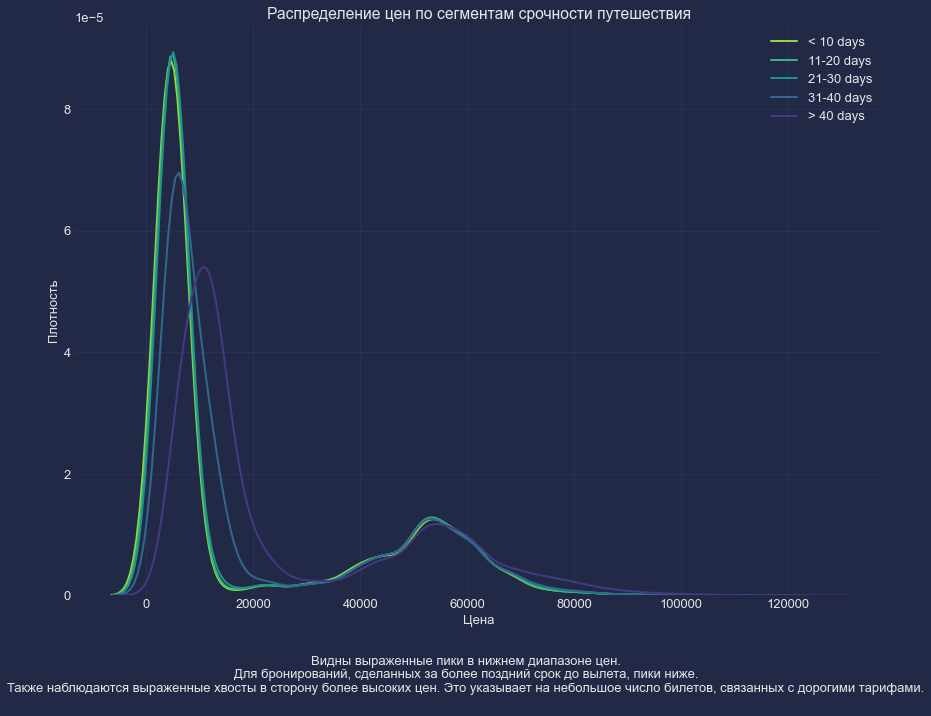

In [171]:
# Графики плотности для цены
fig = plt.figure(figsize=(12, 9))
sns.kdeplot(data=df, x='price', hue='days_left_segment', palette='viridis', linewidth=2, common_norm=False)
plt.title('Распределение цен по сегментам срочности путешествия')
plt.xlabel('Цена')
plt.ylabel('Плотность')
plt.legend(labels=days_left_labels)
plt.tight_layout()

caption_text = '''
Видны выраженные пики в нижнем диапазоне цен.
Для бронирований, сделанных за более поздний срок до вылета, пики ниже.
Также наблюдаются выраженные хвосты в сторону более высоких цен. Это указывает на небольшое число билетов, связанных с дорогими тарифами.
'''

plt.figtext(0.5, -0.1, caption_text, ha="center", fontsize=13)

pdf.savefig(fig, bbox_inches='tight')

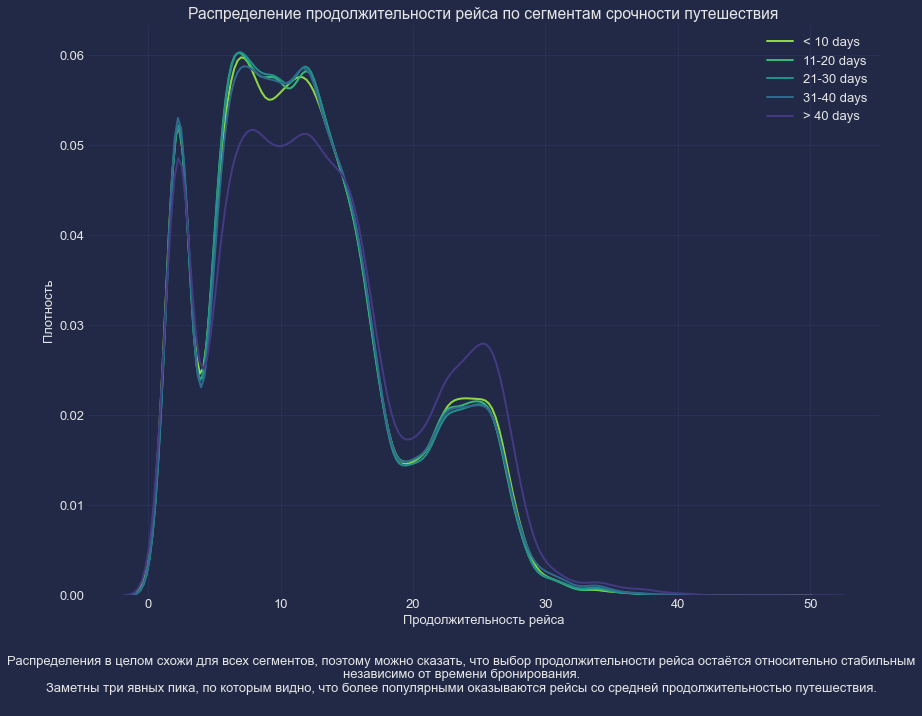

In [172]:
# Графики плотности для продолжительности рейса
fig = plt.figure(figsize=(12, 9))
sns.kdeplot(data=df, x='duration', hue='days_left_segment', palette='viridis', linewidth=2, common_norm=False)
plt.title('Распределение продолжительности рейса по сегментам срочности путешествия')
plt.xlabel('Продолжительность рейса')
plt.ylabel('Плотность')
plt.legend(labels=days_left_labels)
plt.tight_layout()

caption_text = '''
Распределения в целом схожи для всех сегментов, поэтому можно сказать, что выбор продолжительности рейса остаётся относительно стабильным
независимо от времени бронирования.
Заметны три явных пика, по которым видно, что более популярными оказываются рейсы со средней продолжительностью путешествия.
'''

plt.figtext(0.5, -0.1, caption_text, ha="center", fontsize=13)

pdf.savefig(fig, bbox_inches='tight')

In [173]:
def run_ks_tests(df: pd.DataFrame, column: str) -> pd.DataFrame:
    ks_test_results = []
    for i in range(len(days_left_labels)):
        for j in range(i + 1, len(days_left_labels)):
            data1 = df[df['days_left_segment'] == days_left_labels[i]][column]
            data2 = df[df['days_left_segment'] == days_left_labels[j]][column]
            _, p_value = st.ks_2samp(data1, data2)
            ks_test_results.append({
                'segments': f'{days_left_labels[i]} vs {days_left_labels[j]}',
                f'p_value_{column}': p_value
            })
    return pd.DataFrame(ks_test_results)

ks_tests_price = run_ks_tests(df, 'price')
ks_tests_duration = run_ks_tests(df, 'duration')
ks_tests = ks_tests_price.copy()
ks_tests['p_value_duration'] = ks_tests_duration['p_value_duration']
ks_tests

segments  p_value_price  p_value_duration
0   < 10 days vs 11-20 days     0.00000000        0.00000000
1   < 10 days vs 21-30 days     0.00000000        0.00000000
2   < 10 days vs 31-40 days     0.00000000        0.00000000
3    < 10 days vs > 40 days     0.00000000        0.00000000
4  11-20 days vs 21-30 days     0.00000000        0.03201582
5  11-20 days vs 31-40 days     0.00000000        0.02830571
6   11-20 days vs > 40 days     0.00000000        0.05323315
7  21-30 days vs 31-40 days     0.00000000        0.92142546
8   21-30 days vs > 40 days     0.00000000        0.03848005
9   31-40 days vs > 40 days     0.00000000        0.12642043

По результатам тестов Колмогорова-Смирнова можно сделать следующие выводы:
* для всех сравнений между сегментами по цене билета $\textit{p_value}$ равны нулю, что говорит о статистически значимых различиях в распределении цен между группами. Таким образом, цены на билеты, скорее всего, варьируются в зависимости от времени, оставшегося до вылета.
* для сравнений по продолжительности видно отсутствие статистически значимых различий в распределении продолжительности рейсов между сегментами $\textit{11-20 days}$ и $\textit{>40 days}$, а также между $\textit{21-30 days}$ и $\textit{31-40 days}$ ($\textit{p_value} > 0.5$). Сравнение всех сегментов с сегментом $\textit{< 10 days}$ показало нулевые $p\_value$, что указывает на статистически значимые различия между этой группой и остальными. Возможно, пассажиры, бронирующие билеты в последние дни, выбирают рейсы с отличающейся продолжительностью из-за срочных обстоятельств или отличающейся ценовой политики. 

# Проверка гипотез

Поскольку число групп для сравнения равно $5 > 2$, то будем для проверки гипотез применять попарные сравнения с помощью $t$-теста Стьюдента, а также дисперсионный анализ ($\textit{ANOVA}$).

Узнаем, есть ли статистически значимые различия в средней стоимости билета в зависимости от количества дней до рейса.  
**Нулевая гипотеза $H_0$**: cредняя стоимость билета во всех сегментах одинакова;  
**Альтернативная гипотеза $H_1$:** хотя бы в одной группе средняя стоимость билета отличается от средней стоимости в других группах. 

Также узнаем, присутствуют ли статистически значимые различия в средней продолжительности полёта в зависимости от срочности бронирования. Для этого определим две гипотезы:  
**Нулевая гипотеза $H_0$**: cредняя продолжительность полёта во всех сегментах одинакова;  
**Альтернативная гипотеза $H_1$:** хотя бы в одной группе средняя продолжительность полёта отличается от средней продолжительности путешествия в других группах. 

In [174]:
segments_price = [df[df['days_left_segment'] == days_left_labels[i]]['price'] for i in range(len(days_left_labels))]
segments_duration = [df[df['days_left_segment'] == days_left_labels[i]]['duration'] for i in range(len(days_left_labels))]

In [175]:
def run_ttests(df: pd.DataFrame, column: str):
    ttest_results = []
    for i in range(len(days_left_labels)):
        for j in range(i + 1, len(days_left_labels)):
            _, p_value = st.ttest_ind(
                df[df['days_left_segment'] == days_left_labels[i]][column],
                df[df['days_left_segment'] == days_left_labels[j]][column],
                equal_var=False
            )
            ttest_results.append({
            'segments': f'{days_left_labels[i]} vs {days_left_labels[j]}',
            f'p_value_{column}': p_value
            })
    return pd.DataFrame(ttest_results)
ttests_price = run_ttests(df, 'price')
ttests_duration = run_ttests(df, 'duration')
ttests_results = ttests_price.copy()
ttests_results['p_value_duration'] = ttests_duration['p_value_duration']
ttests_results

segments  p_value_price  p_value_duration
0   < 10 days vs 11-20 days     0.00000000        0.00000000
1   < 10 days vs 21-30 days     0.00000000        0.00000000
2   < 10 days vs 31-40 days     0.00000000        0.00000000
3    < 10 days vs > 40 days     0.00000000        0.00000000
4  11-20 days vs 21-30 days     0.00000000        0.00143771
5  11-20 days vs 31-40 days     0.00000000        0.00176270
6   11-20 days vs > 40 days     0.00000000        0.21460412
7  21-30 days vs 31-40 days     0.06532494        0.95114631
8   21-30 days vs > 40 days     0.00007365        0.06638726
9   31-40 days vs > 40 days     0.02864927        0.07545451

In [176]:
st.f_oneway(*segments_price)

F_onewayResult(statistic=868.367729165154, pvalue=0.0)

In [177]:
st.f_oneway(*segments_duration)

F_onewayResult(statistic=219.60005811955563, pvalue=1.509254769847995e-188)

$\textit{ANOVA}$ для средней стоимости билета показал присутствие статистически значимых различий между сегментами бронирований – это согласуется с большинством попарных сравнений, проведённых с помощью теста Стьюдента. Исключение составила пара сегментов $\textit{21-30 days}$ и $\textit{31-40 days}$ $(\textit{p_value}$ больше уровня значимости $0.05$).

Для средней продолжительности полёта $\textit{ANOVA}$ также показал наличие статистически значимых различий между группами. При этом $t$-тесты дали более конкретное представление о разнице между отдельными сегментами, показав отсутствие значимых различий между парами $\textit{11-20 days}$ и $\textit{> 40 days}$, $\textit{21-30 days}$ и $\textit{31-40 days}$, $\textit{21-30 days}$ и $\textit{> 40 days}$, $\textit{31-40 days}$ и $\textit{> 40 days}$.

## Точечные и интервальные оценки разницы между группами

Точечная оценка разницы математических ожиданий покажет, насколько в среднем одна группа отличается от другой по изучаемому признаку. Оценка является несмещённой и состоятельной.

In [178]:
means_diff = {}
for i in range(len(days_left_labels)):
    for j in range(i + 1, len(days_left_labels)):
        segments_means_diff = {}
        segments_means_diff['mean_diff_price'] = np.mean(segments_price[i]) - np.mean(segments_price[j])
        segments_means_diff['mean_diff_duration'] = np.mean(segments_duration[i]) - np.mean(segments_duration[j])
        means_diff[f'{days_left_labels[i]} vs {days_left_labels[j]}'] = segments_means_diff
pd.DataFrame(means_diff).T

mean_diff_price  mean_diff_duration
< 10 days vs 11-20 days     4822.27620173          0.96388581
< 10 days vs 21-30 days     6456.96386736          1.08939116
< 10 days vs 31-40 days     6688.98605998          1.08700432
< 10 days vs > 40 days      6974.00950705          1.01479657
11-20 days vs 21-30 days    1634.68766563          0.12550534
11-20 days vs 31-40 days    1866.70985825          0.12311851
11-20 days vs > 40 days     2151.73330532          0.05091076
21-30 days vs 31-40 days     232.02219262         -0.00238684
21-30 days vs > 40 days      517.04563969         -0.07459459
31-40 days vs > 40 days      285.02344707         -0.07220775

In [179]:
# Бутстрап-доверительные интервалы
def calc_bootstrap_conf_int(sample1: pd.Series, sample2: pd.Series, alpha: int=0.05):
    means_diff = []
    for _ in range(1000):
        sample1_ = np.random.choice(sample1, size=len(sample1), replace=True)
        sample2_ = np.random.choice(sample2, size=len(sample2), replace=True)
        means_diff.append(np.mean(sample1_) - np.mean(sample2_))
    
    ci_mean = tuple(np.round(np.percentile(means_diff, [100 * alpha / 2, 100 * (1 - alpha / 2)]), 4))
  
    return ci_mean

conf_ints = {}
for i in range(len(days_left_labels)):
    for j in range(i + 1, len(days_left_labels)):
        segments_int = {}
        segments_int['mean_ci_price'] = calc_bootstrap_conf_int(segments_price[i], segments_price[j])
        segments_int['mean_ci_duration'] = calc_bootstrap_conf_int(segments_duration[i], segments_duration[j])
        conf_ints[f'{days_left_labels[i]} vs {days_left_labels[j]}'] = segments_int
pd.DataFrame(conf_ints).T

mean_ci_price   mean_ci_duration
< 10 days vs 11-20 days   (4551.5385, 5074.1818)   (0.8773, 1.0543)
< 10 days vs 21-30 days   (6214.9253, 6726.8137)   (1.0114, 1.1725)
< 10 days vs 31-40 days   (6420.0617, 6951.7135)    (1.0028, 1.186)
< 10 days vs > 40 days    (6711.5254, 7229.4534)   (0.9212, 1.1086)
11-20 days vs 21-30 days  (1395.2695, 1871.0252)   (0.0453, 0.2012)
11-20 days vs 31-40 days  (1626.8818, 2122.9482)   (0.0462, 0.1983)
11-20 days vs > 40 days   (1901.3438, 2381.9023)  (-0.0315, 0.1325)
21-30 days vs 31-40 days     (-4.0601, 482.1679)  (-0.0796, 0.0769)
21-30 days vs > 40 days      (265.866, 772.2689)  (-0.1585, 0.0104)
31-40 days vs > 40 days      (36.1708, 554.7581)  (-0.1532, 0.0047)

Многие доверительные интервалы не содержат ноль, что говорит о наличии статистически значимых различий между отдельными группами бронирований по количеству дней до путешествия. Все доверительные интервалы, содержащие ноль, соответствуют ситуации, когда тест Стьюдента принимает нулевую гипотезу о равенстве средних. Иными словами, наблюдается согласованность полученных результатов теста Стьюдента с соответствующими доверительными интервалами.

# Продуктовые гипотезы

Анализ показал, что группа бронирований, сделанных менее чем за $10$ дней до вылета, имеет значительно более высокую среднюю цену по сравнению с бронированиями, сделанными заранее. Ясно, что одна из причин этого – стратегиии управления доходами авиакомпании. Однако не стоит забывать про особенности поведения потребителей.  Исходя из полученных данных, можно сформировать несколько продуктовых гипотез для повышения эффективности бизнеса.

**Гипотеза 1: уведомления о ценовых изменениях**. Если авиакомпании предоставят автоматические уведомления о снижении цен на билеты для тех, кто подписан на рассылку и часто путешествует, это снизит среднюю цену покупки в сегменте бронирований, сделанных менее чем за $10$ дней до вылета.  
**Эксперимент**: внедрить систему рассылки уведомлений об изменении цен и анализировать изменения в средних ценах билетов и общем количестве бронирований.

**Гипотеза 2: программа гибких скидок**. Если авиакомпания введёт программу скидок, которая предлагает постепенно увеличивающиеся скидки по мере приближения к дате вылета для рейсов с низкой загрузкой, это приведёт к снижению средней цены билетов в последние $10$ дней до вылета и повышению общей загрузки.  
**Эксперимент**: Провести A/B-тестирование, предложив скидки на выбранных рейсах, и сравнить показатели с контрольной группой без скидок.

**Гипотеза 3: динамическое ценообразование**. Если авиакомпания использует более продвинутую модель динамического ценообразования, основанную на машинном обучении, которая учитывает не только срочность, но и другие факторы (такие как история цен, спрос, конкуренция и т.д.), средняя цена билетов во всех сегментах выровняется.  
**Эксперимент**: Внедрить новую систему динамического ценообразования для тестовой группы рейсов и изучить её влияние на распределение цен по сравнению с традиционной моделью.
 
Средняя продолжительность рейса также значительно отличается у группы бронирований, сделанных менее, чем за $10$ дней, по сравнению с другими группами.

**Гипотеза 1: программа лояльности**. Нехватка дополнительных стимулов для выбора длительных рейсов приводит к их низкой популярности. 
**Эксперимент**: ввести дополнительные мили или бонусы в программы лояльности за бронирование более длительных рейсов, отследить изменение в поведении бронирования и доходах.

**Гипотеза 2: ценовая привлекательность**. Пассажиры предпочитают короткие рейсы из-за более низкой цены.   
**Эксперимент**: Предложить скидки или льготные условия для длительных рейсов, такие как включение дополнительных услуг в стоимость билета (например, питание, выбор места, дополнительный багаж) и проанализировать изменение среднего дохода на пассажира и загрузки рейсов.



# Обучение модели линейной регрессии

Для начала преобразуем категориальные признаки в числовой формат.

In [180]:
encoded_df = df.copy()
encoded_df.drop('days_left_segment', axis=1, inplace=True)

# Преобразование категориальных признаков в числовые
label_encoder = LabelEncoder()
for col in encoded_df.columns:
    if encoded_df[col].dtype == 'object':
        encoded_df[col] = label_encoder.fit_transform(encoded_df[col])  
        
encoded_df.head()

airline  flight  source_city  departure_time  stops  arrival_time  \
0        4    1408            2               2      2             5   
1        4    1387            2               1      2             4   
2        0    1213            2               1      2             1   
3        5    1559            2               4      2             0   
4        5    1549            2               4      2             4   

   destination_city  class   duration  days_left  price  
0                 5      1 2.17000000          1   5953  
1                 5      1 2.33000000          1   5953  
2                 5      1 2.17000000          1   5956  
3                 5      1 2.25000000          1   5955  
4                 5      1 2.33000000          1   5955

In [181]:
# Разобьём датасет на тренировочную и тестовую выборки
encoded_df_train, encoded_df_test = train_test_split(encoded_df, test_size=0.2, random_state=42)

In [182]:
def train_model(
    dataset: pd.DataFrame,
    target: str,
    feature_names: list[str],
    show_results: bool=False,
    pairwise: bool=False,
    robust: bool=False):

    dataset = dataset.copy()

    # Создадим матрицу фичей
    X = sm.add_constant(dataset[feature_names])
    
    # Зафитим модель на данные. y - наша целевая переменная, X - матрица факторов
    if robust == True:
        model = sm.OLS(dataset[target], X).fit(cov_type='HC0')
    else:
        model = sm.OLS(dataset[target], X).fit()
    
    dataset[f'{target}_hat'] = model.fittedvalues
    dataset['residuals'] = model.resid
    
    if show_results:
        # Выведем результат построения регрессии
        print(model.summary())
        
        # Выведем графики с результатами модели
        plot_data(dataset, target, feature_names, plot_type='model', pairwise=pairwise, model=model)
    
    return dataset, model

In [183]:
def plot_data(
    dataset: pd.DataFrame,
    target: str,
    feature_names: list[str],
    plot_type: str=None,
    pairwise: bool=False,
    model: sm.OLS=None):

    dataset = dataset.copy()
    # Графики с результатами моделирования
    if plot_type == 'model':

        if pairwise == True:
            
            plt.figure(figsize=(12, 9))
            feat = feature_names[0]
            # Давайте посмотрим, как соотносится реальная выборка с предсказанными значениями
            sb.scatterplot(data=dataset, x=feat, y=target);
            sb.lineplot(x=dataset[feat], y=dataset[f'{target}_hat'], c = 'r');
            plt.xlabel(f'{feat} values')
            plt.ylabel(f'{target} values')
            plt.title(f'{target} vs {feat} distribution and model fit')
            plt.show()

        else:

            # Чтобы сделать функцию гибкой, пройдемся по фичам из списка
            for feat in feature_names:
                
                
                '''
                Предскажем значение таргета при фиксированных средних
                значениях всех перменных, кроме рассматриваемой. И отрисуем
                зависимость между этим фактором и предсказанным таргетом
                '''
                dataset_paired = pd.DataFrame(
                    data = [dataset[feature_names].mean()],
                    index = dataset.index
                    )
                dataset_paired[feat] = dataset[feat]
                dataset_paired['const'] = 1.0
                dataset_paired = dataset_paired[['const'] + feature_names]
                target_paired = model.predict(dataset_paired)
                
                plt.figure(figsize=(12, 9))
                # Давайте посмотрим, как соотносится реальная выборка с предсказанными значениями
                sb.scatterplot(data=dataset, x=feat, y=target);
                sb.lineplot(x=dataset[feat], y=target_paired, c = 'r');
                plt.xlabel(f'{feat} values')
                plt.ylabel(f'{target} values')
                plt.title(f'{target} vs {feat} distribution and model fit')
                plt.show()
                
                plt.figure(figsize=(12, 9))
                # Также посмотрим распределение остатков модели относительно факторов
                sb.scatterplot(data=dataset, x=feat, y='residuals');
                sb.lineplot(x=dataset[feat], y=dataset['residuals'].mean(), c='black', linestyle='--');
                plt.xlabel(f'{feat} values')
                plt.ylabel(f'Residuals values')
                plt.title(f'Residuals vs {feat} distribution and model fit')
                plt.show()
        
        plt.figure(figsize=(12, 9))
        # Отрисует предсказанные и реальные значения таргета
        sb.scatterplot(data=dataset, x=f'{target}_hat', y=target);
        sb.lineplot(data=dataset, x=target, y=target, c='black', linestyle='--');
        plt.xlabel('Predicted value')
        plt.ylabel('Actual value')
        plt.title('Model fit vs actual data')
        plt.show()
        
        # А также посмотрим на распределение остатков модели
        sb.displot(dataset['residuals'], bins=20, kde=True, height=12, aspect=12/9);
        plt.xlabel('Model residuals')
        plt.ylabel('Residuals frequency')
        plt.title('Model residuals histogram')
        plt.show()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 2.278e+05
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:01:59   Log-Likelihood:            -2.4670e+06
No. Observations:              240122   AIC:                         4.934e+06
Df Residuals:                  240111   BIC:                         4.934e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5.044e+04     79.300  

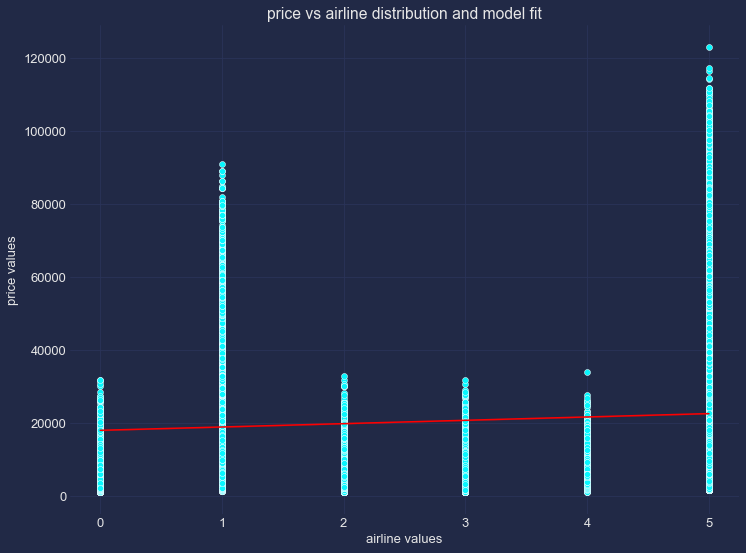

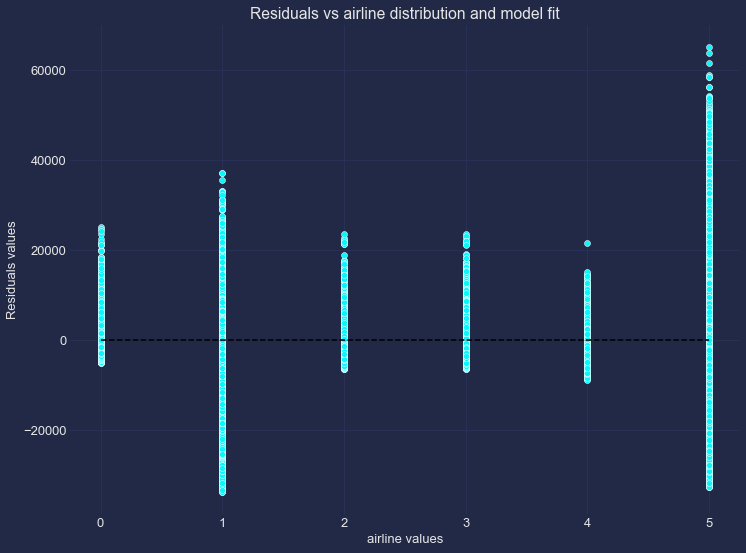

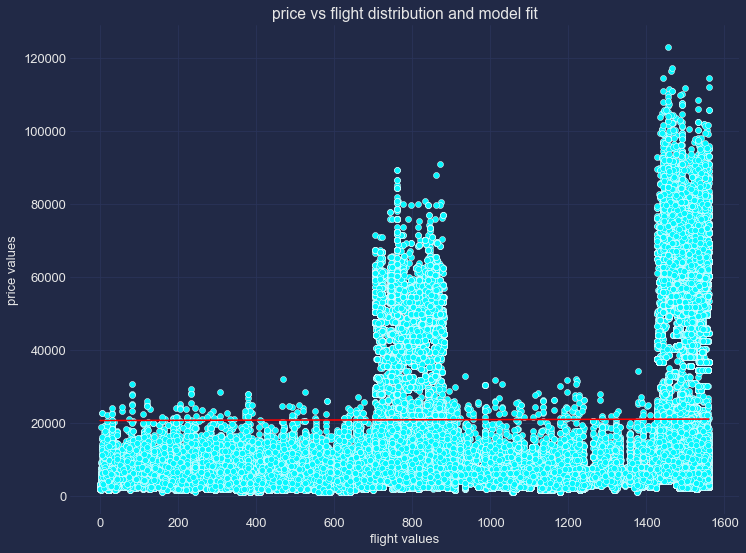

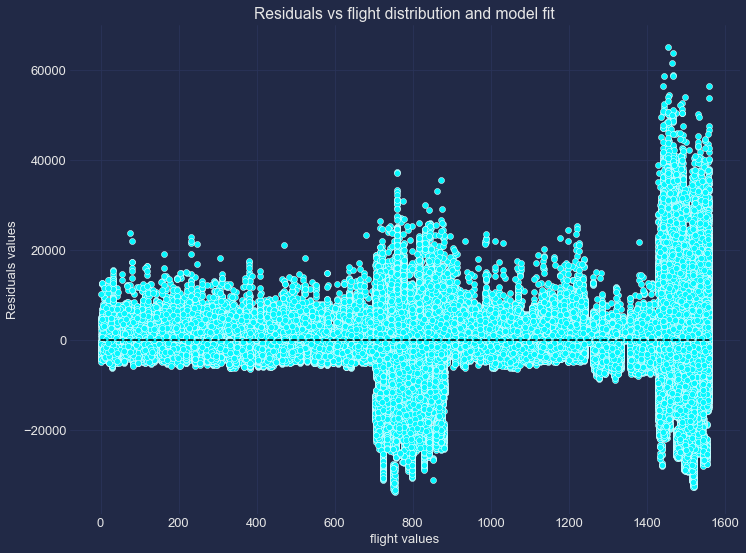

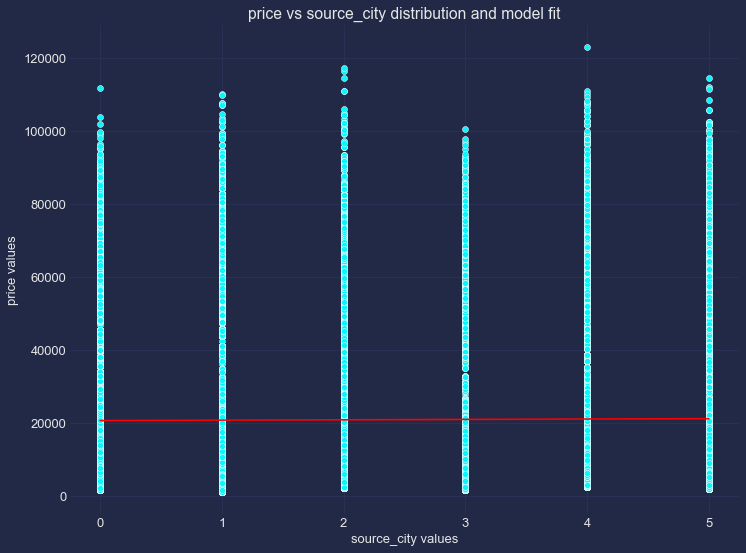

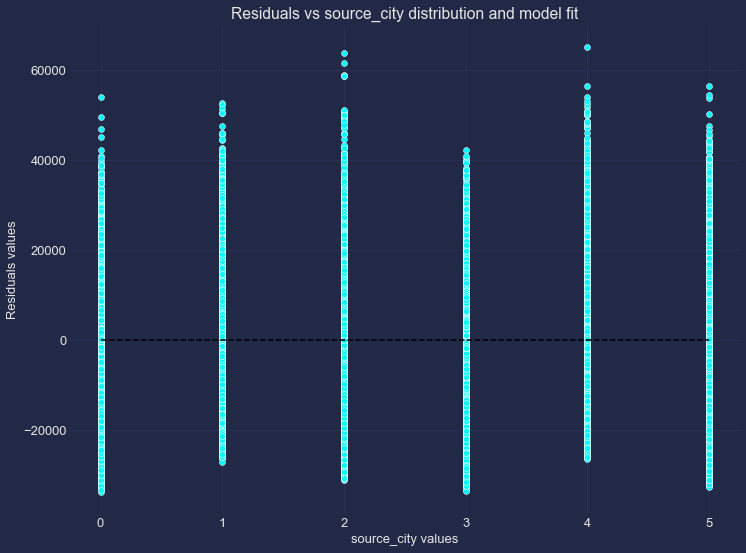

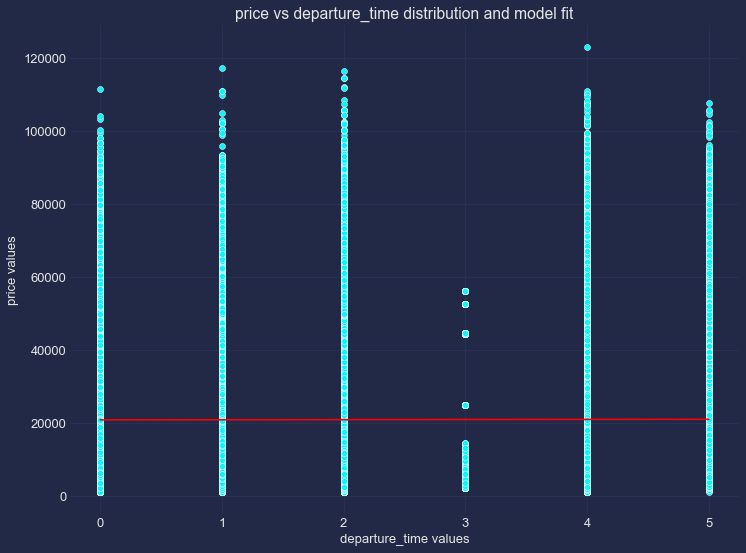

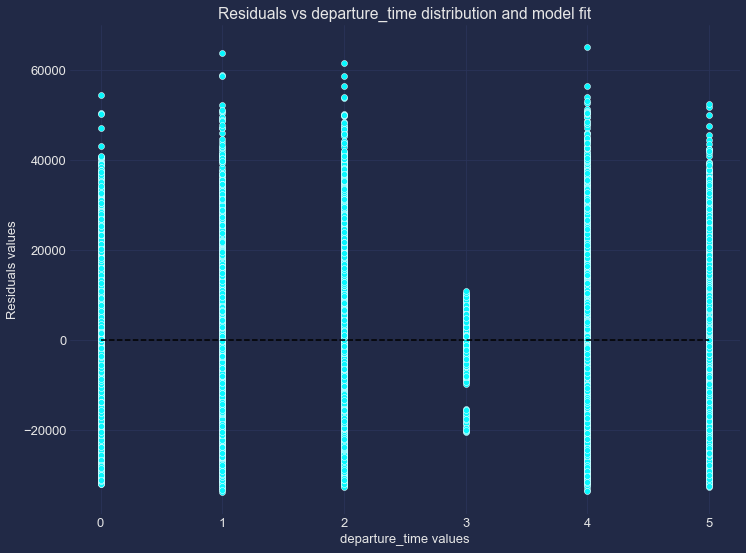

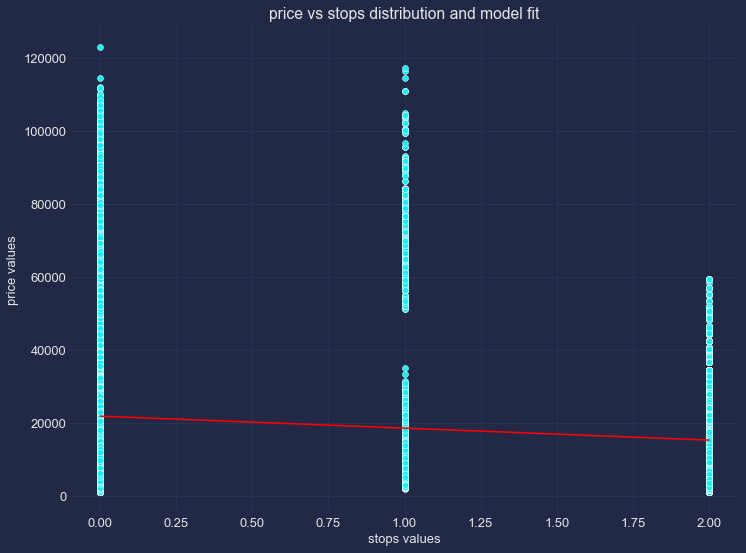

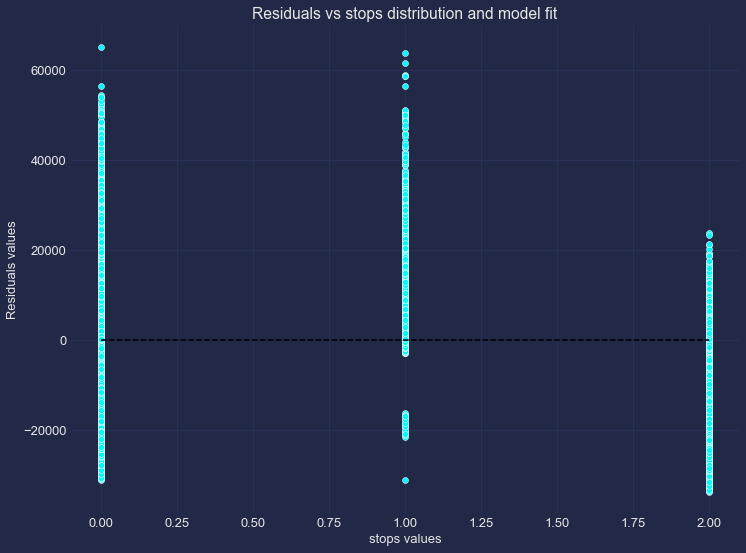

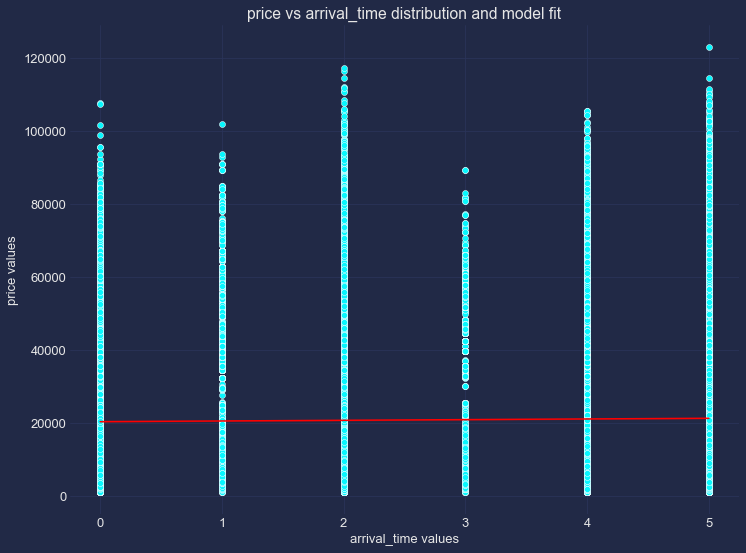

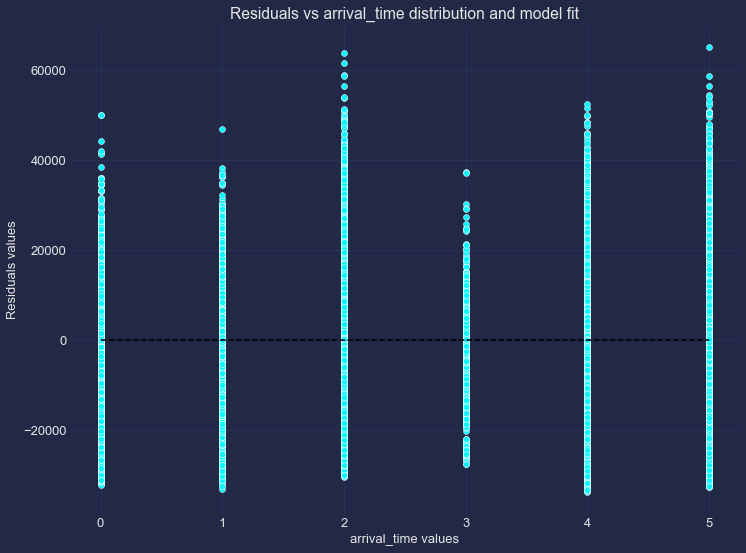

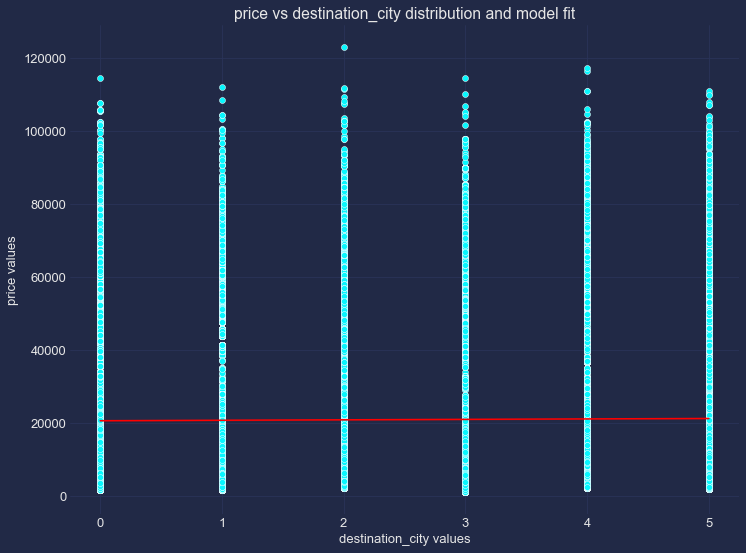

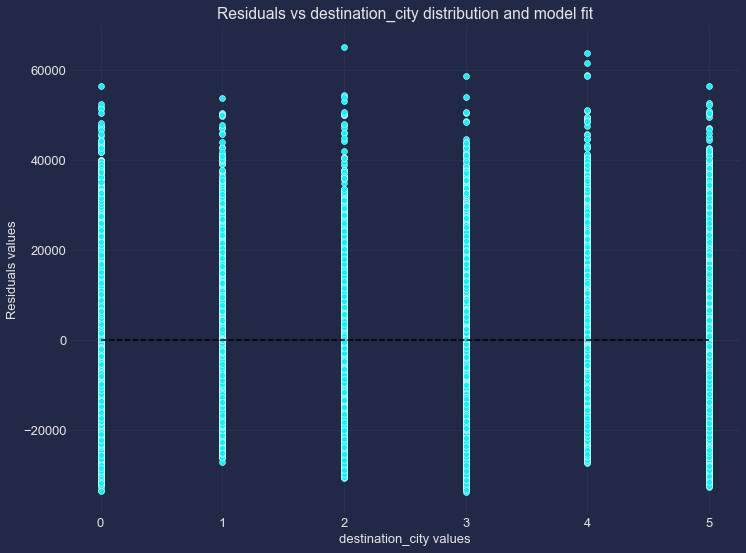

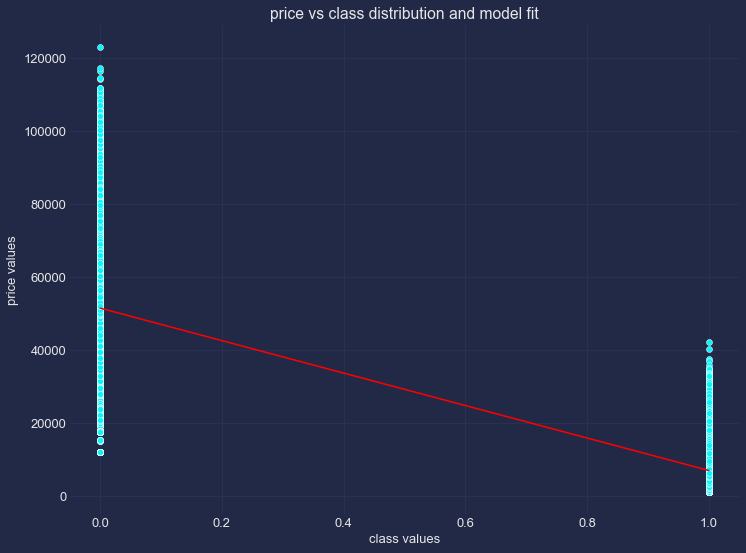

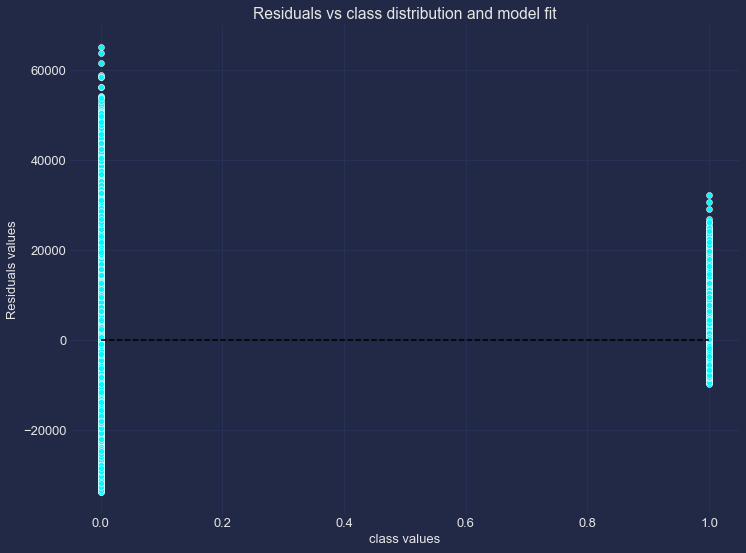

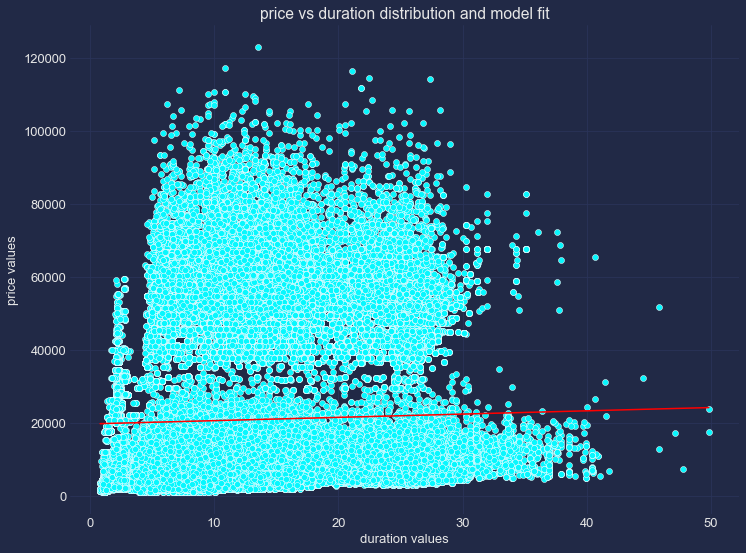

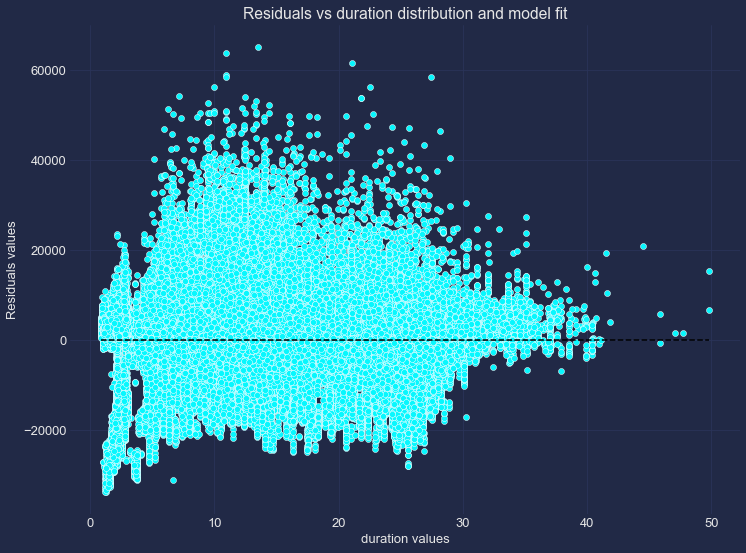

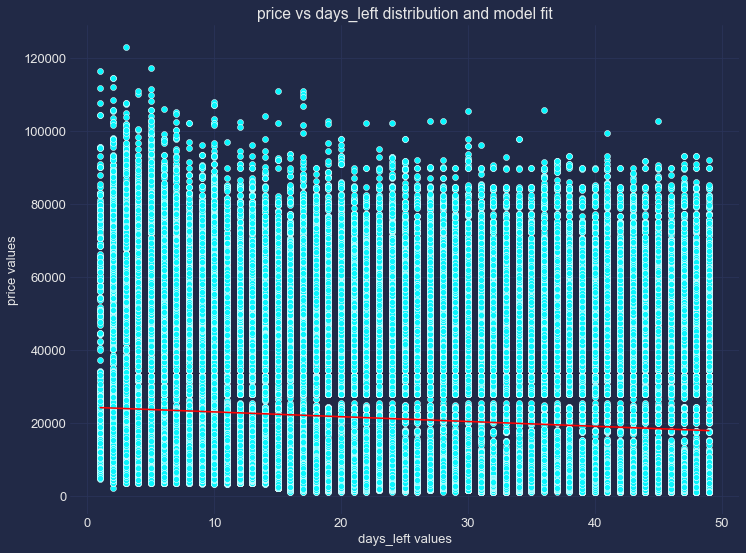

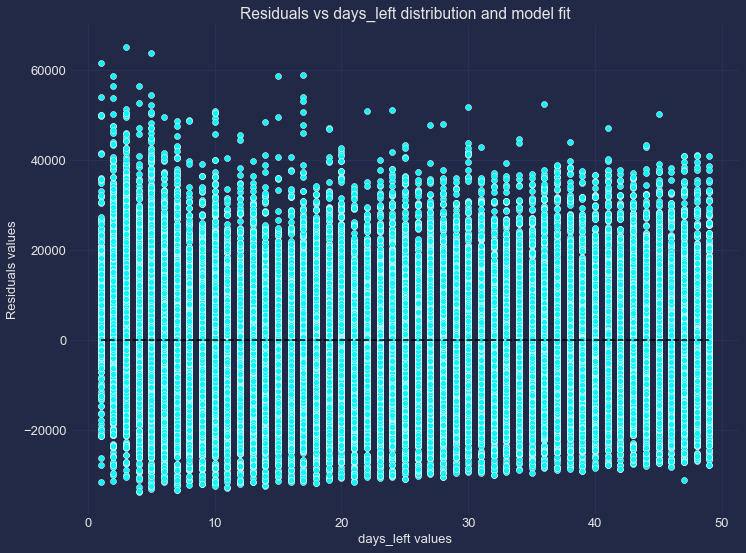

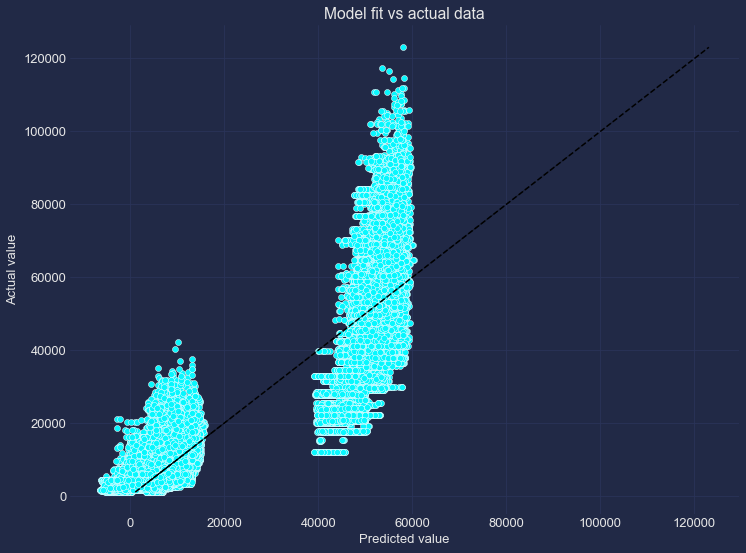

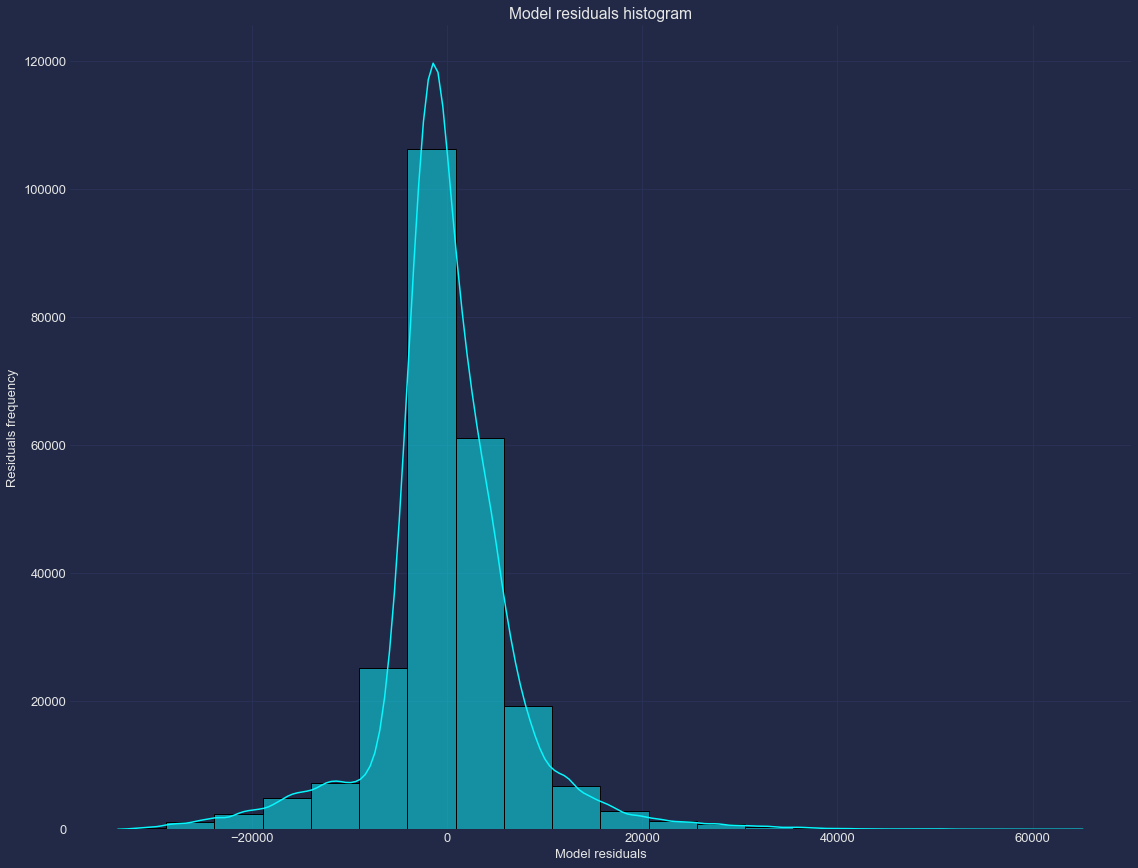

In [184]:
# Обучим модель и выведем результаты
dt_linearity, model_linearity = train_model(encoded_df_train, target='price', feature_names=encoded_df.columns[:-1].tolist(), show_results=True)

По отчёту видно, что все факторы, за исключением фактора $\textit{flight}$ оказывают влияние на зависимую переменную $\textit{price}$. Особенно заметны высокие оценки коэффициентов при факторах $\textit{stops}$ и $\textit{class}$, что говорит о сильном влиянии количества остановок и класса пассажирского места на ценообразование билета. Коэффициент детерминации $R^2$ довольно высокий, однако по графикам зависимости переменной $\textit{price}$ от регрессоров прослеживается явная нелинейная взаимосвязь, что не удовлетворяет первой предпосылке Гаусса-Маркова о линейной взаимосвязи зависимой переменной с регрессорами. Такую модель, конечно, можно использовать, но это решение будет не самым эффективным. К тому же, никто не гарантирует, что не начнут нарушаться другие предпосылки. Сомнения вызывает также высокий $\textit{Condition_Number}$, который может указывать на возможную мультиколлинеарность между регрессорами.

## Тесты на мультиколлинеарность

In [185]:
# Ввиду большого числа регрессоров ограничимся просмотром матрицы корреляции вместо матрицы рассеяния
encoded_df.iloc[:, :-1].corr()

airline      flight  source_city  departure_time  \
airline           1.00000000  0.63791836  -0.02835029      0.05688469   
flight            0.63791836  1.00000000  -0.00944335      0.07156397   
source_city      -0.02835029 -0.00944335   1.00000000     -0.00468791   
departure_time    0.05688469  0.07156397  -0.00468791      1.00000000   
stops            -0.02983839 -0.11883307   0.00181915     -0.00851809   
arrival_time      0.03771412  0.06717532   0.04415254     -0.04628236   
destination_city -0.03017203 -0.03624842  -0.22293481     -0.00176119   
class            -0.17886197 -0.25953113   0.00007537     -0.05333960   
duration         -0.00165093  0.20550168   0.00861935      0.08434832   
days_left        -0.01067783 -0.00044349  -0.00356838     -0.00159682   

                       stops  arrival_time  destination_city       class  \
airline          -0.02983839    0.03771412       -0.03017203 -0.17886197   
flight           -0.11883307    0.06717532       -0.03624842 -0.25953113   
source_city       0.00181915    0.04415254       -0.22293481  0.00007537   
departure_time   -0.00851809   -0.04628236       -0.00176119 -0.05333960   
stops             1.00000000    0.01051499       -0.01284615  0.10026152   
arrival_time      0.01051499    1.00000000       -0.03743053 -0.02764675   
destination_city -0.01284615   -0.03743053        1.00000000  0.00160301   
class             0.10026152   -0.02764675        0.00160301  1.00000000   
duration         -0.47385953    0.00867914        0.00173551 -0.13870993   
days_left        -0.00704693   -0.00419139       -0.00532282  0.01303858   

                    duration   days_left  
airline          -0.00165093 -0.01067783  
flight            0.20550168 -0.00044349  
source_city       0.00861935 -0.00356838  
departure_time    0.08434832 -0.00159682  
stops            -0.47385953 -0.00704693  
arrival_time      0.00867914 -0.00419139  
destination_city  0.00173551 -0.00532282  
class            -0.13870993  0.01303858  
duration          1.00000000 -0.03915688  
days_left        -0.03915688  1.00000000

In [186]:
# Посчитаем VIF для каждого фактора
def calc_VIF(dataset: pd.DataFrame, feature_names: list[str]):
    
    # Считаем VIF 
    X = sm.add_constant(dataset[feature_names])
    VIFs = pd.Series(
        [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
        index=X.columns)
    
    # Создадим датафрейм с VIF значениями
    dt = pd.DataFrame(VIFs).reset_index()
    dt.columns = ['Feature', 'VIF']
    display(dt)
    
calc_VIF(encoded_df, encoded_df.columns[:-1])

Feature         VIF
0              const 30.76241948
1            airline  1.74704140
2             flight  1.87348916
3        source_city  1.05533438
4     departure_time  1.01622151
5              stops  1.29654494
6       arrival_time  1.01050119
7   destination_city  1.05530407
8              class  1.08495222
9           duration  1.38615828
10         days_left  1.00308350

По матрице корреляции видна высокая положительная корреляция между регрессорами $\textit{flight}$ и $\textit{airline}$. В целом, можно попробовать исключить регрессор $\textit{flight}$ из модели, так как его влияние на зависимую переменную невелико, но тогда оценки коэффициентов окажутся смещёнными. Можно оставить как есть, тогда доверительные интервалы коэффициентов модели окажутся шире.

Значения метрики $\textit{VIF}$ довольно низки. Значит, проблема высокого $\textit{Condition_Number}$ вовсе не в мультиколлинеарности. Скорее всего, проблема заключается в разных масштабах переменных, поэтому нужно попробовать применить стандартизацию данных.

# Тесты на нормальность распределения остатков

In [188]:
shapiro_test = st.shapiro(model_linearity.resid)
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

# Тест Колмогорова-Смирнова
ks_test = st.kstest(model_linearity.resid, 'norm')
print(f"Kolmogorov-Smirnov test statistic: {ks_test[0]}, p-value: {ks_test[1]}")

Shapiro-Wilk test statistic: 0.9099845290184021, p-value: 0.0
Kolmogorov-Smirnov test statistic: 0.5398478145962805, p-value: 0.0


При больших размерах выборки даже небольшие отклонения от нормальности могут привести к статистически значимым результатам. Поэтому стоит оценить распределение остатков визуально, используя графики квантиль-квантиль.

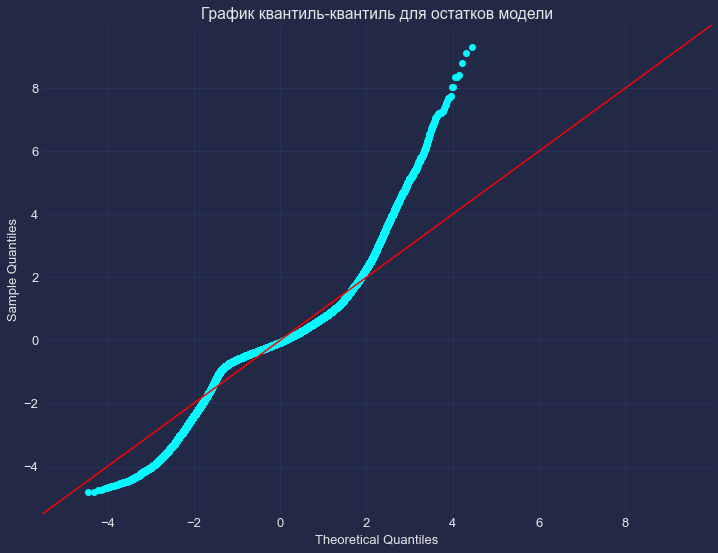

In [189]:
fig, ax = plt.subplots(figsize=(12, 9))
qq = sm.qqplot(model_linearity.resid, line='45', fit=True, ax=ax)
plt.title('График квантиль-квантиль для остатков модели')
plt.show()

На концах графика наблюдается отклонение от прямой линии, поэтому нормальность остатков не наблюдается. Скорее всего, это указывает на проблемы с линейностью в данных или на наличие выбросов.

## Тесты на гетероскедастичность

In [193]:
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

white_test = het_white(model_linearity.resid, model_linearity.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

breuschpagan_test = het_breuschpagan(model_linearity.resid, model_linearity.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, breuschpagan_test)))

{'Test Statistic': 75510.14859503364, 'Test Statistic p-value': 0.0, 'F-Statistic': 1720.59487843731, 'F-Test p-value': 0.0}
{'Test Statistic': 50425.24214247794, 'Test Statistic p-value': 0.0, 'F-Statistic': 6382.636926861118, 'F-Test p-value': 0.0}


Результаты тестов Уайта и Бреуша-Пагана указывают на наличие гетероскедастичности в остатках модели. Это означает, что дисперсия ошибок модели не является постоянной по всем регрессорам, поэтому нельзя использовать классические формулы для расчёта доверительных интервалов и дисперсии коэффициентов. Вместо этого будем использовать робастные оценки, устойчивые к гетероскедастичности.

In [194]:
# Проскейлим данные
scaler = StandardScaler(with_mean=False)
encoded_df[encoded_df.columns] = scaler.fit_transform(encoded_df[encoded_df.columns])
scaled_df = encoded_df.copy()
scaled_df.head()

airline     flight  source_city  departure_time      stops  arrival_time  \
0 2.18190338 3.29978776   1.14170969      1.14007324 3.00379870    2.87081873   
1 2.18190338 3.25057218   1.14170969      0.57003662 3.00379870    2.29665499   
2 0.00000000 2.84278590   1.14170969      0.57003662 3.00379870    0.57416375   
3 2.72737922 3.65367125   1.14170969      2.28014647 3.00379870    0.00000000   
4 2.72737922 3.63023526   1.14170969      2.28014647 3.00379870    2.29665499   

   destination_city      class   duration  days_left      price  
0        2.86608468 2.15939733 0.30172476 0.07374098 0.26227293  
1        2.86608468 2.15939733 0.32397174 0.07374098 0.26227293  
2        2.86608468 2.15939733 0.30172476 0.07374098 0.26240510  
3        2.86608468 2.15939733 0.31284825 0.07374098 0.26236104  
4        2.86608468 2.15939733 0.32397174 0.07374098 0.26236104

In [195]:
# Разобьём датасет на тренировочную и тестовую выборки
scaled_df_train, scaled_df_test = train_test_split(scaled_df, test_size=0.2, random_state=42)

In [196]:
# Попробуем дропнуть сильно скоррелированный признак
scaled_df_train.drop('flight', axis=1, inplace=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 1.610e+05
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:12:43   Log-Likelihood:                -58569.
No. Observations:              240122   AIC:                         1.172e+05
Df Residuals:                  240112   BIC:                         1.173e+05
Df Model:                           9                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.2284      0.003  

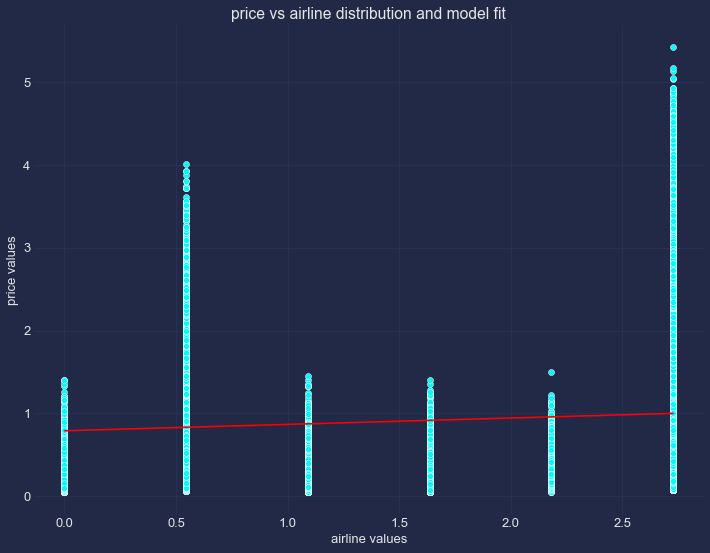

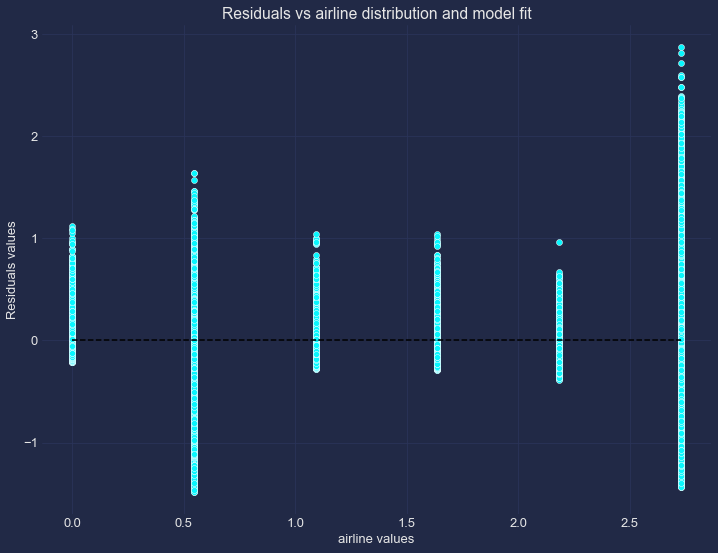

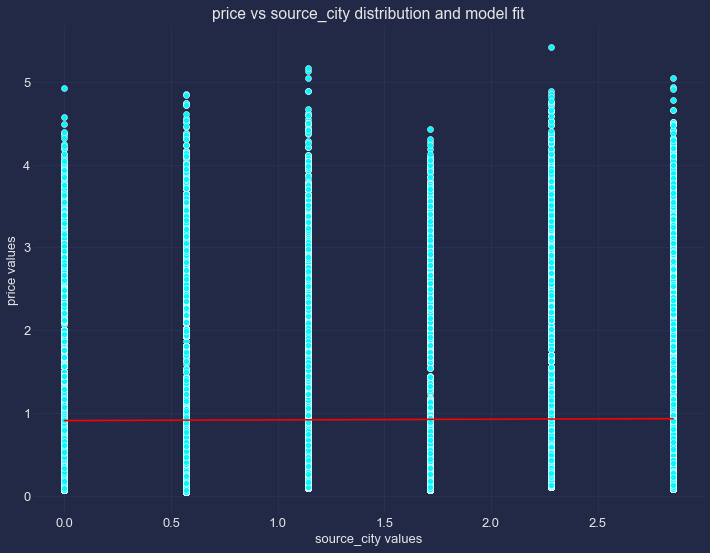

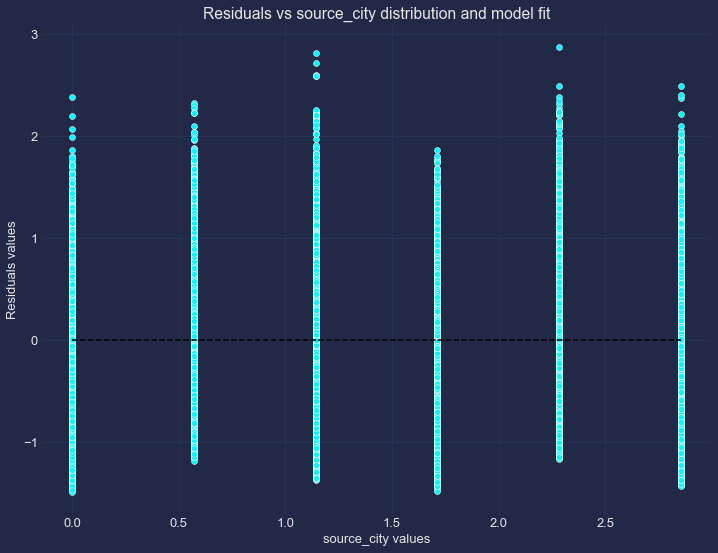

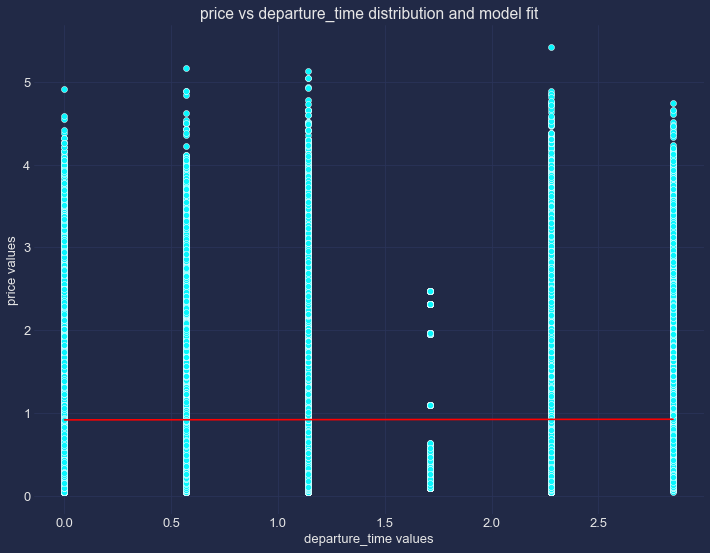

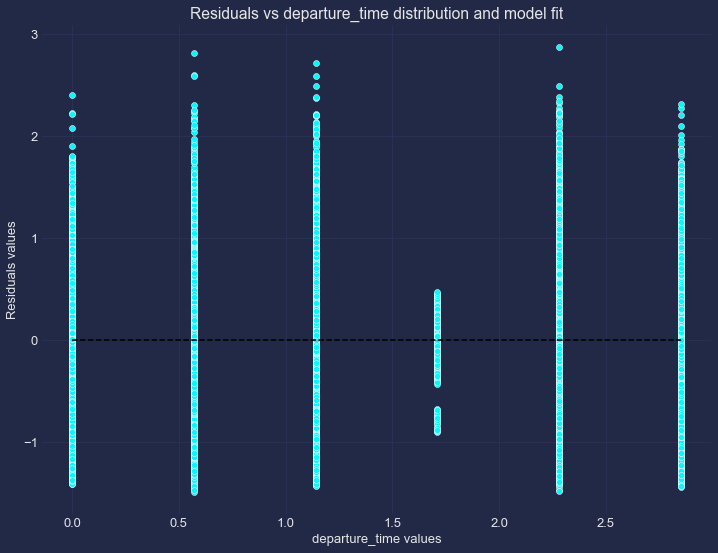

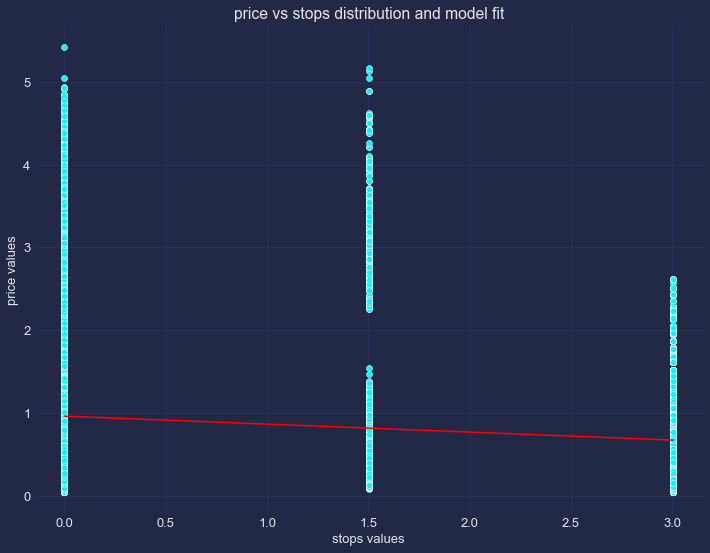

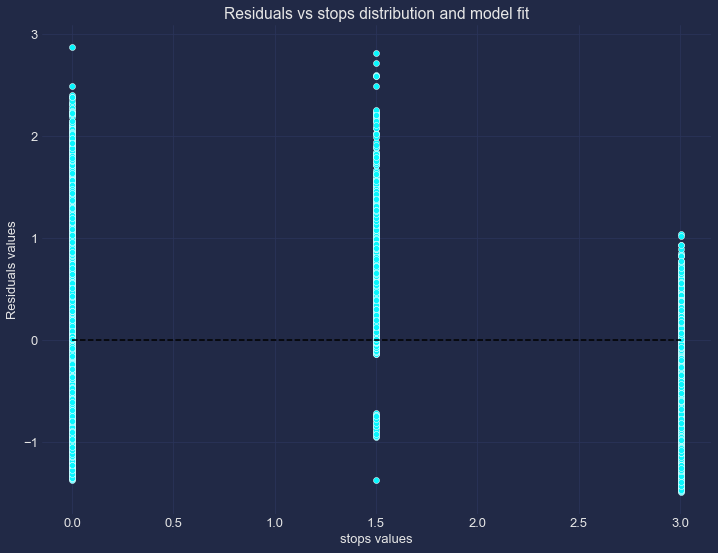

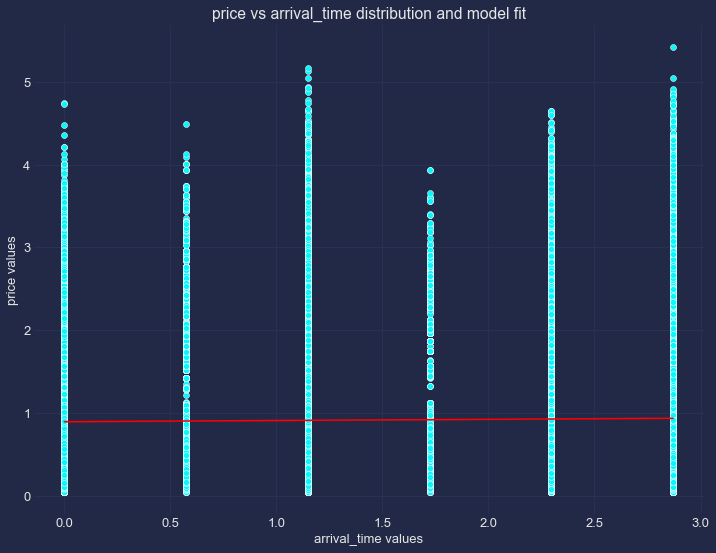

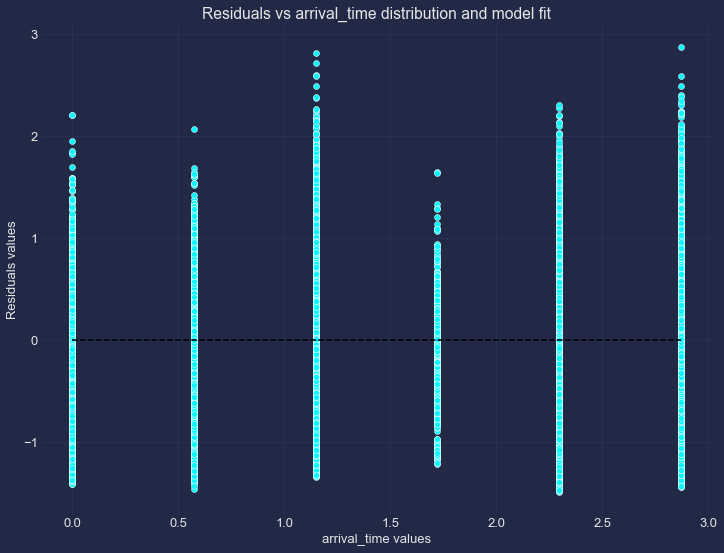

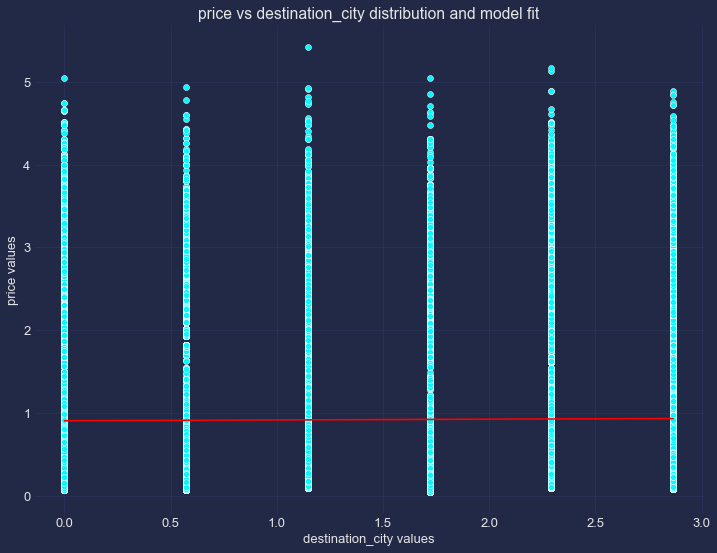

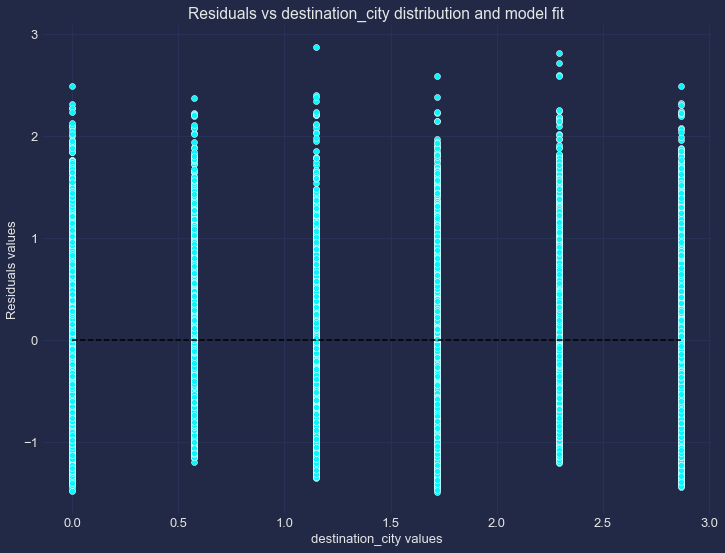

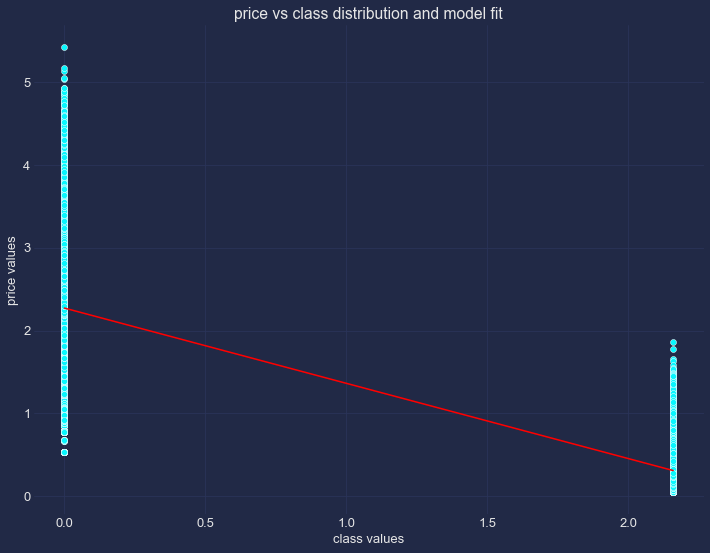

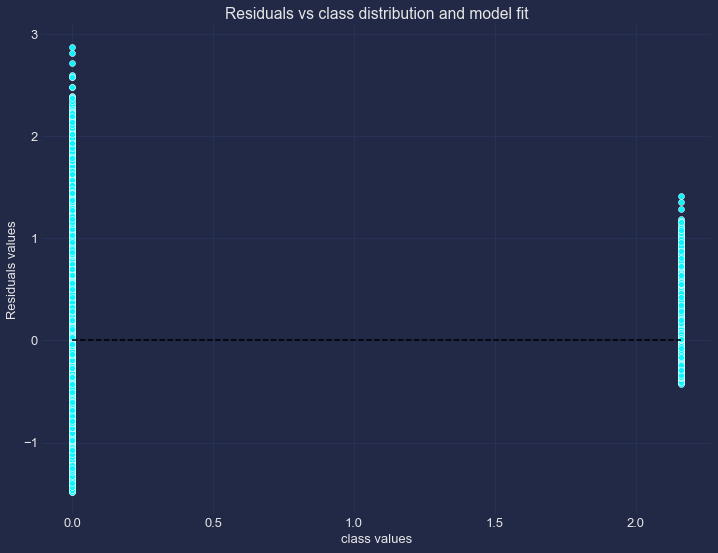

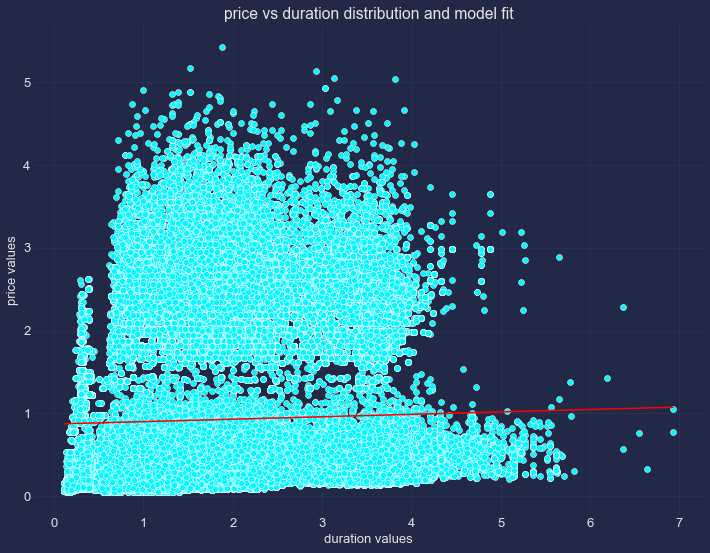

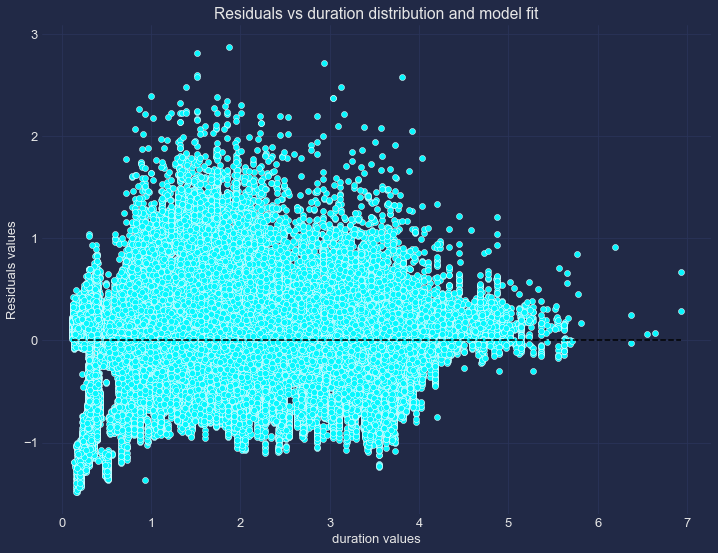

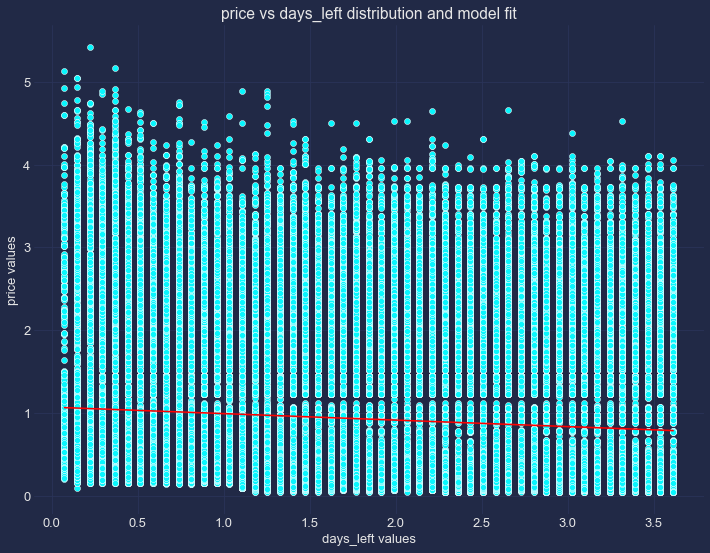

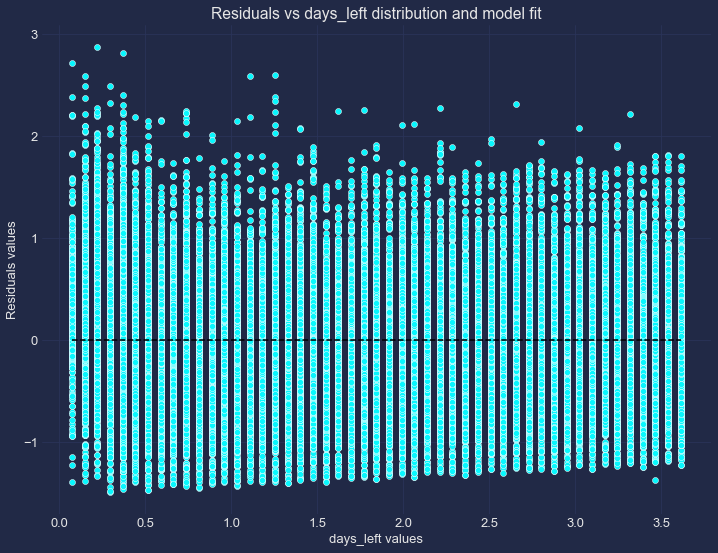

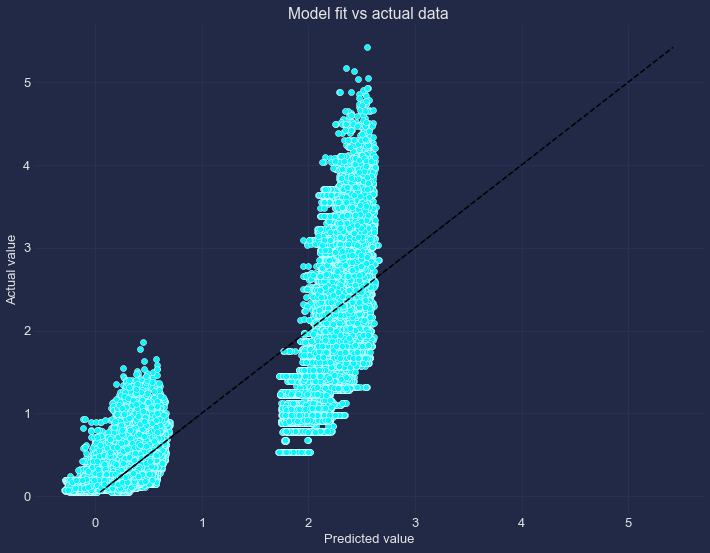

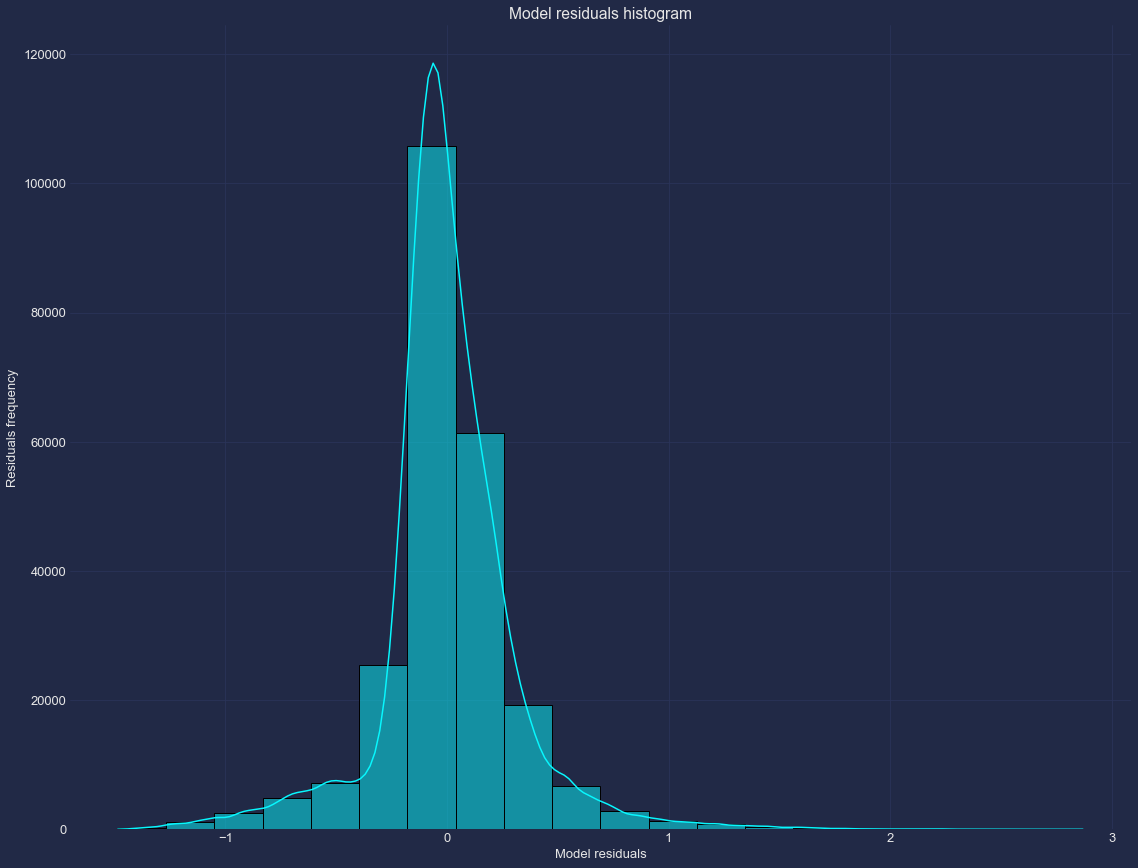

In [197]:
# Обучим модель и выведем результаты
dt_linearity1, model_linearity1 = train_model(scaled_df_train, target='price', feature_names=scaled_df_train.columns[:-1].tolist(), show_results=True, robust=True)

In [198]:
# Ввиду большого числа регрессоров ограничимся просмотром матрицы корреляции вместо матрицы рассеяния
scaled_df_train.iloc[:, :-1].corr()

airline  source_city  departure_time       stops  \
airline           1.00000000  -0.02792524      0.05804126 -0.03031793   
source_city      -0.02792524   1.00000000     -0.00602081  0.00170969   
departure_time    0.05804126  -0.00602081      1.00000000 -0.00689569   
stops            -0.03031793   0.00170969     -0.00689569  1.00000000   
arrival_time      0.03783873   0.04532249     -0.04637715  0.01202176   
destination_city -0.03109506  -0.22383016     -0.00191548 -0.01342571   
class            -0.17781317   0.00082721     -0.05291345  0.09933980   
duration         -0.00175491   0.00885947      0.08281963 -0.47420172   
days_left        -0.01070384  -0.00255738     -0.00215402 -0.00499359   

                  arrival_time  destination_city       class    duration  \
airline             0.03783873       -0.03109506 -0.17781317 -0.00175491   
source_city         0.04532249       -0.22383016  0.00082721  0.00885947   
departure_time     -0.04637715       -0.00191548 -0.05291345  0.08281963   
stops               0.01202176       -0.01342571  0.09933980 -0.47420172   
arrival_time        1.00000000       -0.03796430 -0.02904148  0.00830656   
destination_city   -0.03796430        1.00000000  0.00230049  0.00132667   
class              -0.02904148        0.00230049  1.00000000 -0.13713515   
duration            0.00830656        0.00132667 -0.13713515  1.00000000   
days_left          -0.00301332       -0.00524413  0.01328511 -0.04001005   

                   days_left  
airline          -0.01070384  
source_city      -0.00255738  
departure_time   -0.00215402  
stops            -0.00499359  
arrival_time     -0.00301332  
destination_city -0.00524413  
class             0.01328511  
duration         -0.04001005  
days_left         1.00000000

In [199]:
calc_VIF(scaled_df_train, scaled_df_train.columns[:-1])

Feature         VIF
0             const 27.70435266
1           airline  1.04102616
2       source_city  1.05584018
3    departure_time  1.01571717
4             stops  1.29721373
5      arrival_time  1.00788653
6  destination_city  1.05536391
7             class  1.05626049
8          duration  1.31931458
9         days_left  1.00259625

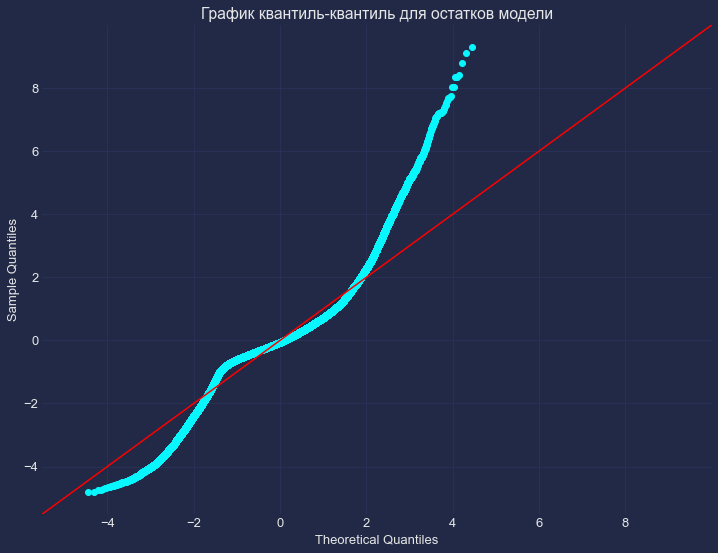

In [200]:
fig, ax = plt.subplots(figsize=(12, 9))
qq = sm.qqplot(model_linearity1.resid, line='45', fit=True, ax=ax)
plt.title('График квантиль-квантиль для остатков модели')
plt.show()

Судя по информационным критериям $\textit{AIC}$ и $\textit{BIC}$, эта спецификация модели оказывается лучше предыдущей в плане соответствия данным. Но особых преимуществ корректировка не принесла. Кажется, что в данных могут присутствовать более сложные взаимосвязи, под которые модели линейной регрессии подстроиться не удаётся. Можно попробовать сгенерировать полиномиальные комбинации исходных признаков, увеличив тем самым гибкость модели без необходимости перехода к сложным моделям. 

In [203]:
# Создание полиномиальных признаков на основе тренировочного набора данных
poly = PolynomialFeatures(degree=4)

scaled_df_train_poly = poly.fit_transform(scaled_df_train.iloc[:, :-1])
scaled_df_train_poly = pd.DataFrame(scaled_df_train_poly, columns=poly.get_feature_names_out(scaled_df_train.iloc[:, :-1].columns), index=scaled_df_train.index)
scaled_df_train_poly['price'] = scaled_df_train['price']
scaled_df_train_poly.head()

1    airline  source_city  departure_time      stops  \
148417 1.00000000 0.54547584   2.28341939      0.00000000 0.00000000   
36879  1.00000000 1.63642753   1.14170969      0.00000000 1.50189935   
274531 1.00000000 0.54547584   2.28341939      0.00000000 0.00000000   
166397 1.00000000 2.72737922   1.71256454      2.85018309 0.00000000   
272722 1.00000000 2.72737922   2.28341939      2.85018309 0.00000000   

        arrival_time  destination_city      class   duration  days_left  ...  \
148417    2.29665499        0.57321694 2.15939733 2.70022800 0.44244586  ...   
36879     2.87081873        0.57321694 2.15939733 0.97330567 0.95863271  ...   
274531    0.00000000        0.57321694 0.00000000 2.94355442 3.24460300  ...   
166397    0.57416375        0.00000000 2.15939733 1.42519758 0.81115075  ...   
272722    2.87081873        0.57321694 0.00000000 3.68465716 0.36870489  ...   

        class duration^3  class duration^2 days_left  \
148417       42.51418627                  6.96616206   
36879         1.99104151                  1.96102579   
274531        0.00000000                  0.00000000   
166397        6.25111935                  3.55782259   
272722        0.00000000                  0.00000000   

        class duration days_left^2  class days_left^3   duration^4  \
148417                  1.14144050         0.18703073  53.16205352   
36879                   1.93146256         1.90234502   0.89742261   
274531                  0.00000000         0.00000000  75.07377910   
166397                  2.02493360         1.15249031   4.12572529   
272722                  0.00000000         0.00000000 184.32673981   

        duration^3 days_left  duration^2 days_left^2  duration days_left^3  \
148417            8.71086837              1.42731935            0.23387341   
36879             0.88389361              0.87056858            0.85744442   
274531           82.75186197             91.21521179          100.54414080   
166397            2.34815524              1.33645181            0.76064112   
272722           18.44463860              1.84566110            0.18468591   

        days_left^4      price  
148417   0.03832133 0.59583052  
36879    0.84451811 0.43792926  
274531 110.82717511 2.46645815  
166397   0.43291865 0.34924198  
272722   0.01848058 2.44526660  

[5 rows x 716 columns]

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     7779.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:27:01   Log-Likelihood:                 29262.
No. Observations:              240122   AIC:                        -5.724e+04
Df Residuals:                  239481   BIC:                        -5.058e+04
Df Model:                         640                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

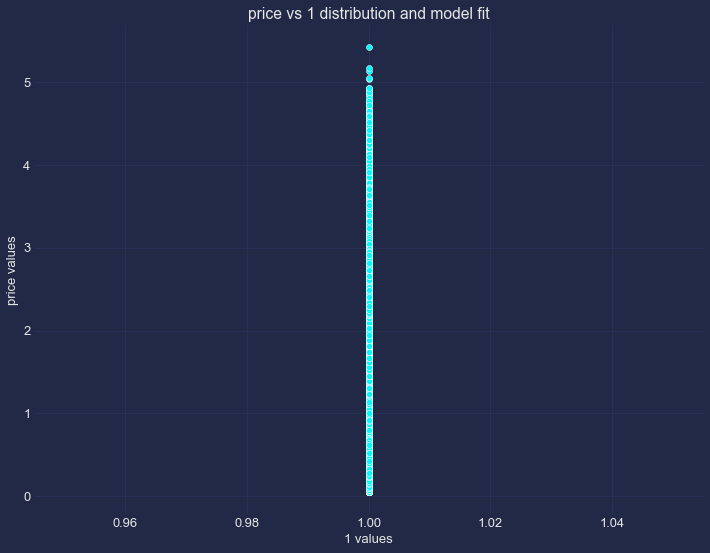

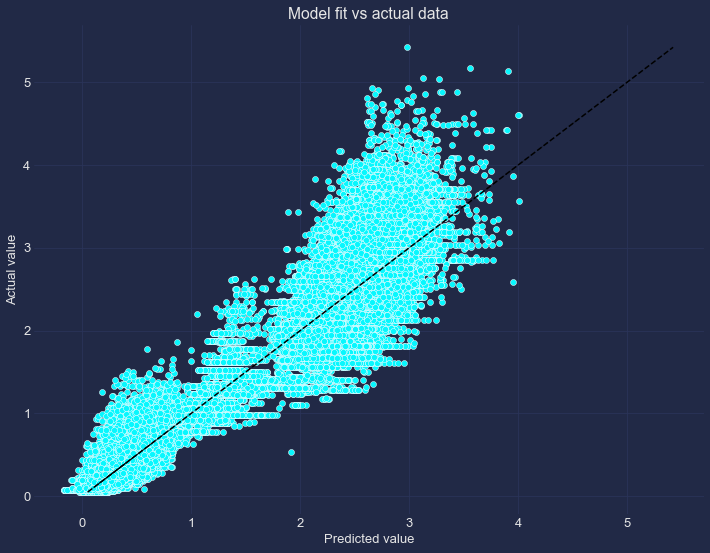

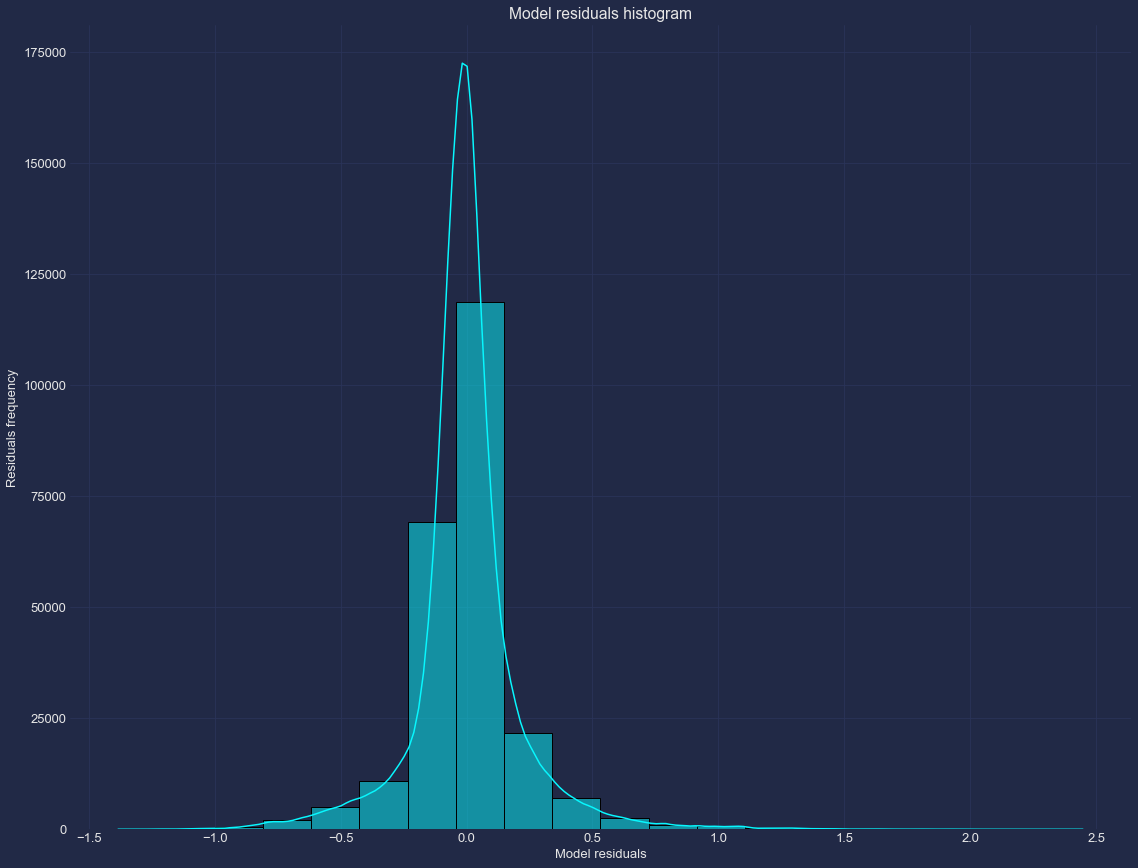

In [206]:
# Обучим модель и выведем результаты
dt_linearity2, model_linearity2 = train_model(scaled_df_train_poly, target='price', feature_names=scaled_df_train_poly.columns[:-1].tolist(), show_results=True, pairwise=True)

Тут фит определённо лучше. Коэффициент детерминации $R^2$ тоже прилично увеличился. Метрики $AIC$ и $BIC$ имеют большие по абсолютной величине отрицательные значения, что говорит о хорошем описании данных моделью. Однако количество признаков в данной модели очень велико. Это может стать проблемой, связанной с переобучением или мультиколлинеарностью и, как следствие, нестабильностью оценок коэффициентов, что видно по высоким стандартным ошибкам для некоторых оценок.

In [207]:
pdf.close()

# Результаты исследования

В ходе проведённого исследования были проанализированы данные о бронированиях авиабилетов. Результаты показали, что большая часть бронирований приходится на рейсы с небольшой продолжительностью. Выдвинута продуктовая гипотеза о предпочтении более коротких рейсов ввиду низкой цены билетов, а также предложен эксперимент для проверки данной гипотезы. Установлены основные показатели, влияющие на ценообразование билета: авиакомпания, класс пассажирского места, продолжительность полёта, срочность бронирования и время отправления. Исследование показало, что авиакомпания с самой высокой средней ценой билета – $\textit{Vistara}$, с самой низкой – $\textit{AirAsia}$, что говорит о качестве оказываемых услуг каждой компанией. Самым популярным маршрутом оказался $\textit{Delhi - Mumbai}$. Средняя цена билета выше в ночное время суток, полёты в дневное время более выгодны. Также установлено, что бронирования, сделанные менее чем за  $10$  дней до вылета, имеет значительно более высокую среднюю цену по сравнению с бронированиями, сделанными заранее. Продолжительность рейсов также оказывается выше для более срочных отправлений. На этот счёт также предложены продуктовые гипотезы и эксперименты, которые могут помочь в увеличении популярности отстающих групп бронирований. Наконец, обучена модель линейной регрессии, а также проведена её оценка методом МНК. Построенная модель может быть эффективно использована в задаче ценообразования билетов.